# Initializations

## imports

In [19]:
from torchvision.datasets import MNIST
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import torch
import torchvision
from torch.autograd import Variable
import pickle
import seaborn as sns
import numpy as np

from tqdm import tqdm

## configs

In [2]:
batch_size_train = 128
batch_size_test = 100
random_seed = 12453211

imbalanced_weights = {
    0: 0.1,
    1: 0.1,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 0.1,
    6: 1.0,
    7: 0.1,
    8: 1.0,
    9: 1.0
}

#2 → 7, 3 → 8, 5 ↔ 6 and 7 → 1 from SL paper
# Creating asymettric noise for 0,3,4 and 8
asymmetric_noise = {
    0: 0,
    1: 1,
    2: 7,
    3: 8,
    4: 4,
    5: 6,
    6: 5,
    7: 1,
    8: 8,
    9: 9
}

torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Data Preparation

## Loading torch dataset

In [3]:

train_set = torchvision.datasets.MNIST(
    '.',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_set = torchvision.datasets.MNIST(
    '.',
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

bal_train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train,
    shuffle=True
)

bal_valid_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size_train,
    shuffle=True,
)

bal_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size_test,
    shuffle=False
)

## loading numpy dataset

In [4]:
def data_loader_to_numpy(data_loader):
    result_x = []
    result_y = []
    for x, y in data_loader:
        result_x.append(x.numpy())
        result_y.append(y.numpy())
        
    return np.concatenate(result_x, axis=0), np.concatenate(result_y, axis=0)
    
train_x, train_y = data_loader_to_numpy(bal_train_loader)
test_x, test_y = data_loader_to_numpy(bal_test_loader)
valid_x, valid_y = data_loader_to_numpy(bal_valid_loader)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(50000, 1, 28, 28) (10000, 1, 28, 28) (50000,) (10000,)


## distribution of classes

<AxesSubplot:ylabel='Count'>

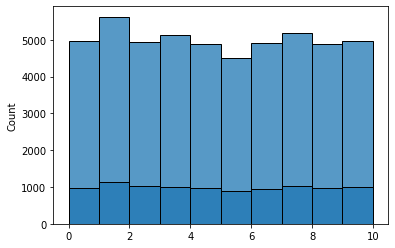

In [5]:
sns.histplot(train_y, bins=[i for i in range(11)])
sns.histplot(test_y, bins=[i for i in range(11)])

<AxesSubplot:>

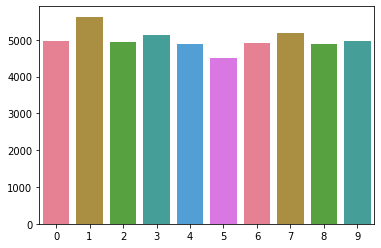

In [6]:
from collections import Counter

train_classes = [label for _, label in train_set]
data_count = Counter(train_classes)
palette = sns.color_palette("husl")
sns.barplot(x=list(data_count.keys()),y=list(data_count.values()),palette=palette)

tensor(3)


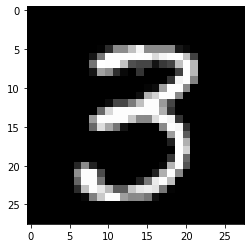

tensor(5)


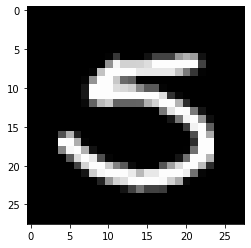

tensor(9)


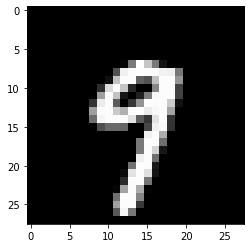

tensor(5)


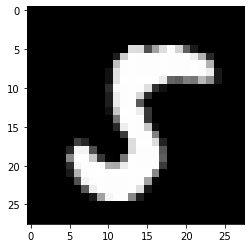

tensor(6)


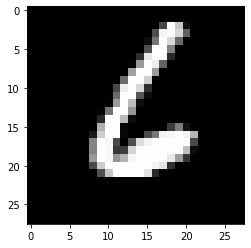

tensor(2)


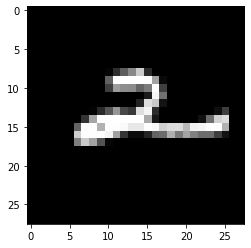

tensor(0)


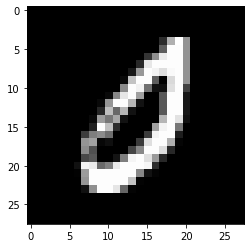

tensor(8)


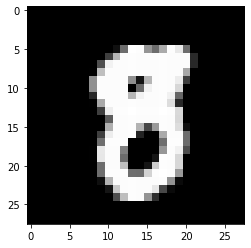

tensor(0)


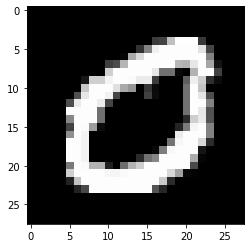

tensor(2)


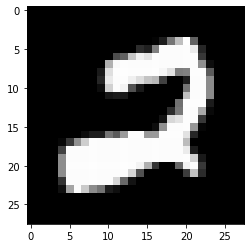

tensor(9)


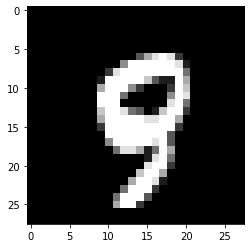

tensor(7)


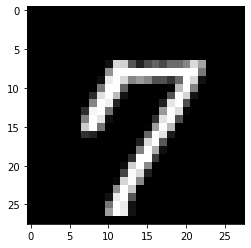

tensor(4)


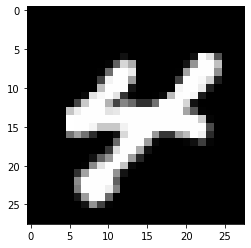

tensor(2)


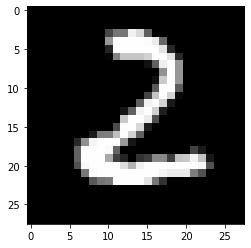

tensor(2)


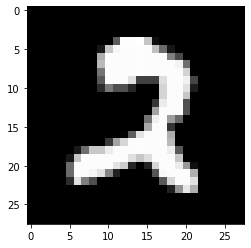

tensor(3)


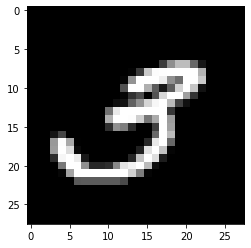

tensor(7)


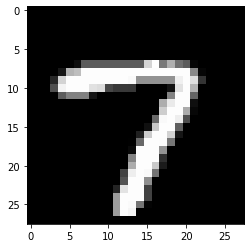

tensor(3)


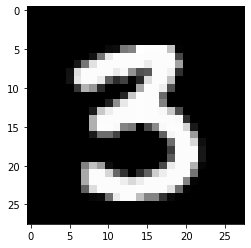

tensor(3)


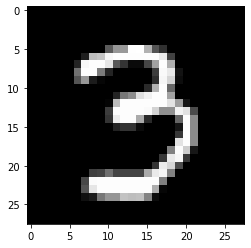

tensor(0)


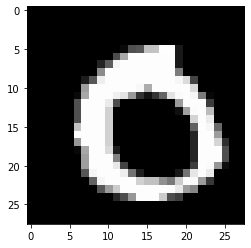

tensor(6)


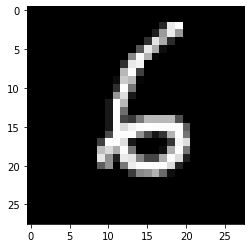

tensor(9)


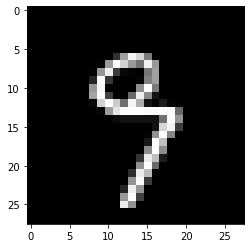

tensor(9)


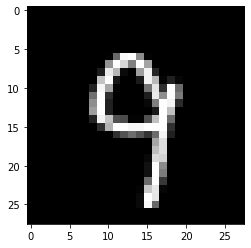

tensor(0)


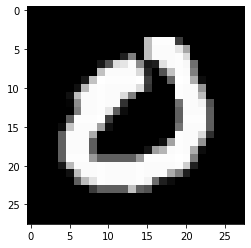

tensor(8)


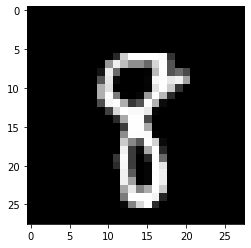

tensor(6)


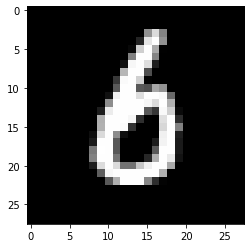

tensor(7)


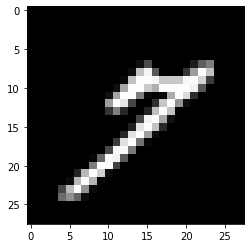

tensor(3)


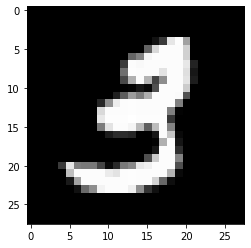

tensor(5)


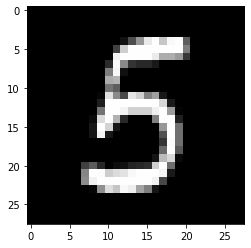

tensor(5)


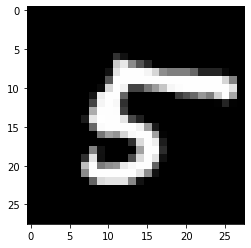

tensor(4)


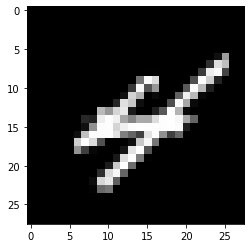

tensor(6)


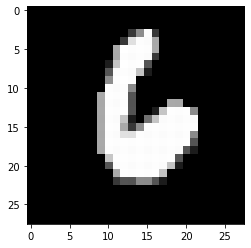

tensor(3)


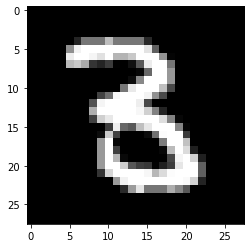

tensor(0)


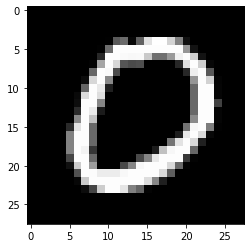

tensor(4)


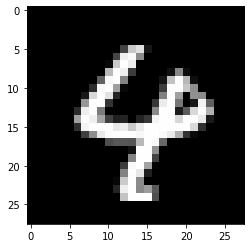

tensor(6)


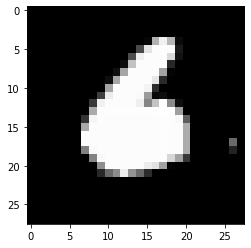

tensor(2)


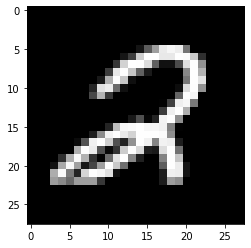

tensor(5)


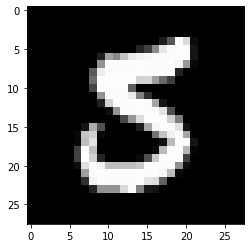

tensor(0)


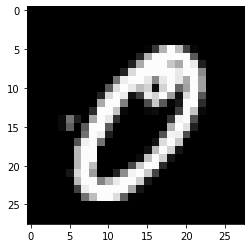

tensor(0)


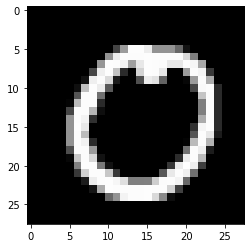

In [7]:
import matplotlib.pyplot as plt

for index, (images,labels) in enumerate(bal_train_loader):
    if index % 10 == 0:
        print(labels[1])
        plt.imshow(images[1].reshape(28,28), cmap="gray")
        plt.show()

## Creating imbalanced dataset

In [8]:
def make_imbalanced(ds_x, ds_y, imbalanced_weights=imbalanced_weights):
    class_partition = {k:[] for k in range(10)}

    for x, y in zip(ds_x, ds_y):
        class_partition[y].append((x, y))

    for i in range(10):
        idxs = np.random.randint(0, len(class_partition[i]), int(imbalanced_weights[i]*len(class_partition[i])))
        class_partition[i] = [class_partition[i][j] for j in idxs]
        print(f"class {i}: size={len(class_partition[i])}")

    imbalanced_train = []

    for partition in class_partition.values():
        imbalanced_train.extend(partition)

    np.random.shuffle(imbalanced_train)
    imbalanced_train_x, imbalanced_train_y = zip(*imbalanced_train)
    
    return imbalanced_train_x, imbalanced_train_y

imb_train_x, imb_train_y = make_imbalanced(train_x, train_y)

class 0: size=496
class 1: size=562
class 2: size=4942
class 3: size=5132
class 4: size=4894
class 5: size=450
class 6: size=4908
class 7: size=518
class 8: size=4891
class 9: size=4960


<AxesSubplot:ylabel='Count'>

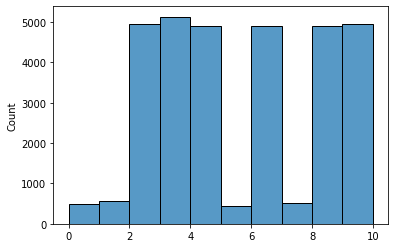

In [9]:
sns.histplot(imb_train_y, bins=[i for i in range(11)])

## create a dataset with symmetric noise

In [10]:
def apply_sym_noise(ds_x, ds_y, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(np.random.randint(10))
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_sym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

## create a dataset with asymmetric noise

In [11]:
def apply_asym_noise(ds_x, ds_y, asym_noise_map=asymmetric_noise, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(asym_noise_map[y])
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_asym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

# Generating All datasets

In [12]:
from torch.utils.data import TensorDataset

def generate_data_loader_from_np(_x, _y, batch_size_train=batch_size_train, valid_frac=0.1):
    tensor_x, tensor_y = torch.Tensor(np.array(_x)), torch.Tensor(np.array(_y)).long()
    train_set = TensorDataset(tensor_x, tensor_y)
    
    valid_size = int(len(train_set)*valid_frac)
    train_size = len(train_set) - valid_size
    
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size_train,
        shuffle=True
    )

    valid_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size_train,
        shuffle=True,
    )
    
    return train_loader, valid_loader


imb_train_loader, imb_valid_loader = generate_data_loader_from_np(imb_train_x, imb_train_y)


In [13]:
#balanced: train_x, train_y
#imbalanced: imb_train_x, imb_train_y
bal_sym_train_x, bal_sym_train_y = apply_sym_noise(train_x, train_y)
bal_asym_train_x, bal_asym_train_y = apply_asym_noise(train_x, train_y)
imb_sym_train_x, imb_sym_train_y = apply_sym_noise(imb_train_x, imb_train_y)
imb_asym_train_x, imb_asym_train_y = apply_asym_noise(imb_train_x, imb_train_y)

#balanced: train_loader
#imbalanced: imb_train_loader
bal_sym_train_loader, bal_sym_valid_loader = generate_data_loader_from_np(bal_sym_train_x, bal_sym_train_y)
bal_asym_train_loader, bal_asym_valid_loader = generate_data_loader_from_np(bal_asym_train_x, bal_asym_train_y)
imb_sym_train_loader, imb_sym_valid_loader = generate_data_loader_from_np(imb_sym_train_x, imb_sym_train_y)
imb_asym_train_loader, imb_asym_valid_loader = generate_data_loader_from_np(imb_asym_train_x, imb_asym_train_y)

<AxesSubplot:ylabel='Count'>

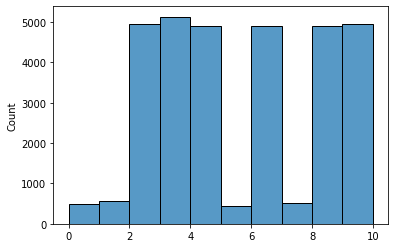

In [14]:
sns.histplot(imb_train_y, bins=[i for i in range(11)])


# Models

## validation functions

### draw confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True)



In [16]:
from sklearn.metrics import classification_report

def clf_metrics(y_true, y_pred, n_class=10):
    class_names = [str(i) for i in range(n_class)]
    print(classification_report(y_true, y_pred, digits=4))
    


## Logistic Regression

### preprocessing data

In [17]:
def preprocess(x, y):
    x, y = np.array(x).squeeze(), np.array(y)
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### model definition

In [42]:
lr = LogisticRegression(
    
    multi_class='ovr',
    random_state=random_seed,
    verbose=True,
) 

lr.fit(train_x, train_y)
y_pred = svm.predict(test_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  3.56581D+04

At iterate   50    f=  1.03141D+03    |proj g|=  3.17595D+01

At iterate  100    f=  9.83512D+02    |proj g|=  8.01004D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    110      1     0     0   8.010D+00   9.835D+02
  F =   983.51238125045086     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  1.09469D+03    |proj g|=  1.59415D+01

At iterate  100    f=  1.03614D+03    |proj g|=  8.93726D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    114      1     0     0   8.937D+00   1.036D+03
  F =   1036.1418203003143     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.73508D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  3.19682D+03    |proj g|=  3.77829D+01


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  3.10326D+03    |proj g|=  1.50223D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    114      1     0     0   1.502D+01   3.103D+03
  F =   3103.2604674215559     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.90443D+04

At iterate   50    f=  3.86220D+03    |proj g|=  3.41590D+01


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  3.78445D+03    |proj g|=  4.24488D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    110      1     0     0   4.245D+01   3.784D+03
  F =   3784.4524199221578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  3.23933D+04

At iterate   50    f=  2.27201D+03    |proj g|=  7.22647D+01

At iterate  100    f=  2.17455D+03    |proj g|=  1.30612D+01

       

/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  4.09818D+03    |proj g|=  1.10329D+02

At iterate  100    f=  3.95811D+03    |proj g|=  1.71250D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    112      1     0     0   1.713D+01   3.958D+03
  F =   3958.1072358418560     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.94212D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  1.67260D+03    |proj g|=  2.64388D+01

At iterate  100    f=  1.62325D+03    |proj g|=  1.00284D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    116      1     0     0   1.003D+01   1.623D+03
  F =   1623.2460841622335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  3.08107D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  2.13891D+03    |proj g|=  4.03928D+01

At iterate  100    f=  2.07884D+03    |proj g|=  1.89532D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    109      1     0     0   1.895D+01   2.079D+03
  F =   2078.8387577443223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.55138D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  5.63835D+03    |proj g|=  4.13856D+01

At iterate  100    f=  5.56927D+03    |proj g|=  2.87040D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    115      1     0     0   2.870D+01   5.569D+03
  F =   5569.2715350589388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.71090D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  4.71919D+03    |proj g|=  6.54175D+01

At iterate  100    f=  4.63855D+03    |proj g|=  5.22290D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    113      1     0     0   5.223D+01   4.639D+03
  F =   4638.5508410830344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.5s finished


ValueError: X has 784 features, but SVC is expecting 10 features as input.

In [43]:
lr.coef_.shape

(10, 784)

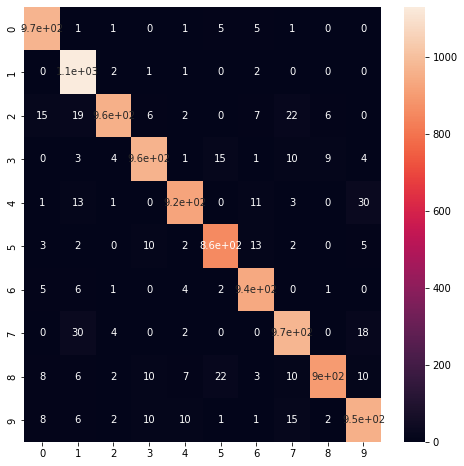

In [44]:
conf_mat(test_y, y_pred)

### model report

In [45]:
clf_metrics(test_y, y_pred)

              precision    recall  f1-score   support

           0     0.9602    0.9857    0.9728       980
           1     0.9292    0.9947    0.9609      1135
           2     0.9825    0.9254    0.9531      1032
           3     0.9630    0.9535    0.9582      1010
           4     0.9685    0.9399    0.9540       982
           5     0.9500    0.9585    0.9542       892
           6     0.9562    0.9802    0.9680       958
           7     0.9392    0.9475    0.9433      1028
           8     0.9803    0.9199    0.9492       974
           9     0.9344    0.9455    0.9399      1009

    accuracy                         0.9554     10000
   macro avg     0.9564    0.9551    0.9554     10000
weighted avg     0.9560    0.9554    0.9553     10000



### train on all datasets

In [20]:
import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    
    lr = LogisticRegression(
        multi_class='ovr',
        random_state=random_seed,
        verbose=False,
        n_jobs=-1
    )  

    lr.fit(_x, _y)
    with open(f'lr-{name}', 'wb') as f:
        pickle.dump(lr, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:05<00:00, 10.94s/it]


### load and test lr model

In [21]:
for model_name in ['lr-balanced', 'lr-imbalanced', 'lr-bal_sym',
                  'lr-bal_asym', 'lr-imb_sym', 'lr-imb_asym']:
    with open(model_name, 'rb') as f:
        lr = pickle.load(f)

    print(model_name)
    
    y_pred = lr.predict(test_x)
    clf_metrics(test_y, y_pred)

lr-balanced
              precision    recall  f1-score   support

           0     0.9458    0.9786    0.9619       980
           1     0.9512    0.9789    0.9648      1135
           2     0.9299    0.8866    0.9077      1032
           3     0.9016    0.9069    0.9042      1010
           4     0.9148    0.9297    0.9222       982
           5     0.8895    0.8576    0.8733       892
           6     0.9358    0.9436    0.9397       958
           7     0.9301    0.9193    0.9247      1028
           8     0.8717    0.8789    0.8753       974
           9     0.8976    0.8860    0.8918      1009

    accuracy                         0.9178     10000
   macro avg     0.9168    0.9166    0.9166     10000
weighted avg     0.9176    0.9178    0.9175     10000

lr-imbalanced
              precision    recall  f1-score   support

           0     0.9770    0.9092    0.9419       980
           1     0.9769    0.9295    0.9526      1135
           2     0.8835    0.8963    0.8899      103

## Embed-rf

### umap embeddings

In [32]:
import umap

def encode_dataset(_x, reducer=None):
    if reducer is None:
        reducer = umap.UMAP(n_components=5, n_jobs=-1)
        reducer.fit(_x)
    return reducer.transform(_x), reducer
    


### training on all datasets

In [33]:
%%time

import pickle
from sklearn.ensemble import RandomForestClassifier

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    
    _x, reducer = encode_dataset(_x)
    
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=random_seed,
        n_jobs=-1
    ) 

    rf.fit(_x, _y)
    
    with open(f'erf-{name}', 'wb') as f:
        pickle.dump(rf, f)
        
    with open(f'erf-{name}-encoder', 'wb') as f:
        pickle.dump(reducer, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:18<00:00, 23.14s/it]

CPU times: user 10min 51s, sys: 2min 36s, total: 13min 27s
Wall time: 2min 18s


### validate

In [34]:
for model_name in ['erf-balanced', 'erf-imbalanced', 'erf-bal_sym', 'erf-bal_asym', 'erf-imb_sym', 'erf-imb_asym']:
    with open(model_name, 'rb') as f:
        erf = pickle.load(f)

    with open(f"{model_name}-encoder", 'rb') as f:
        reducer = pickle.load(f)
        
    print(model_name)
    encode_x = encode_dataset(test_x, reducer)[0]
    y_pred = erf.predict(encode_x)
    clf_metrics(test_y, y_pred)

erf-balanced
              precision    recall  f1-score   support

           0     0.9556    0.9888    0.9719       980
           1     0.9270    0.9956    0.9601      1135
           2     0.9856    0.9293    0.9566      1032
           3     0.9602    0.9545    0.9573      1010
           4     0.9725    0.9379    0.9549       982
           5     0.9592    0.9496    0.9544       892
           6     0.9591    0.9802    0.9695       958
           7     0.9411    0.9475    0.9443      1028
           8     0.9793    0.9251    0.9514       974
           9     0.9337    0.9495    0.9415      1009

    accuracy                         0.9562     10000
   macro avg     0.9573    0.9558    0.9562     10000
weighted avg     0.9569    0.9562    0.9561     10000

erf-imbalanced
              precision    recall  f1-score   support

           0     0.9881    0.9286    0.9574       980
           1     0.9381    0.9877    0.9622      1135
           2     0.9690    0.9399    0.9543      1

## visualize embedding space

In [ ]:
with open(f"erf-balanced-encoder", 'rb') as f:
        reducer = pickle.load(f)
        
embedding = encode_dataset(test_x, reducer)[0]


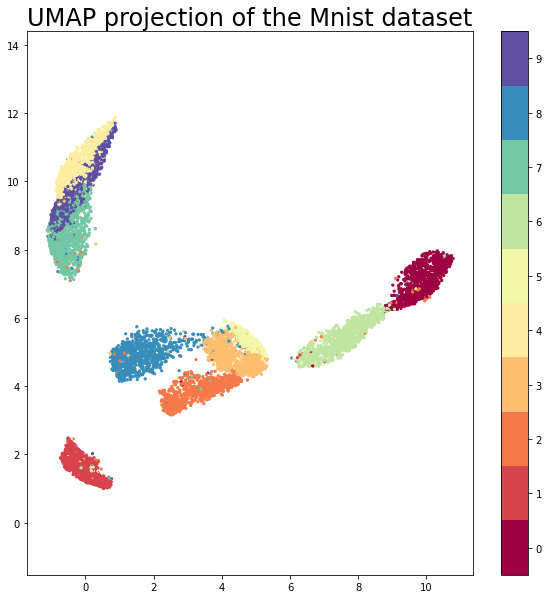

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=test_y, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Mnist dataset', fontsize=24);

## SVM

### preprocessing data

In [21]:
def preprocess(x, y):
    x, y = np.array(x).squeeze(), np.array(y)
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### model definition

In [25]:
svm = SVC(
    kernel='rbf',
    decision_function_shape='ovr',
    random_state=random_seed,
    verbose=True,
) 

svm.fit(train_x, train_y)
y_pred = svm.predict(test_x)

[LibSVM]*
optimization finished, #iter = 591
obj = -0.214330, rho = 0.373004
nSV = 67, nBSV = 0
......................*..............*
optimization finished, #iter = 36848
obj = -9.892223, rho = 4.243326
nSV = 301, nBSV = 0
.......*......*
optimization finished, #iter = 13039
obj = -2.908381, rho = 2.822099
nSV = 219, nBSV = 0
..*..*
optimization finished, #iter = 4179
obj = -0.994940, rho = 1.074030
nSV = 165, nBSV = 0
...................................................*.................................*
optimization finished, #iter = 84723
obj = -31.133473, rho = 10.758067
nSV = 326, nBSV = 1
.........*......*
optimization finished, #iter = 15550
obj = -5.314474, rho = 0.553138
nSV = 233, nBSV = 0
..*.*
optimization finished, #iter = 3480
obj = -0.842590, rho = 1.093112
nSV = 148, nBSV = 0
.........................*..................*
optimization finished, #iter = 43702
obj = -13.929025, rho = 2.170399
nSV = 286, nBSV = 0
.....*...*
optimization finished, #iter = 8494
obj = -2.79410

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*............................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [ ]:
svm.coef_.shape

In [ ]:
conf_mat(test_y, y_pred)

### model report

In [ ]:
clf_metrics(test_y, y_pred)

### train on all datasets

In [17]:
import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    svm = SVC(
        kernel='rbf',
        decision_function_shape='ovr',
        random_state=random_seed,
        verbose=True,
    ) 

    svm.fit(_x, _y)
    with open(f'svm-{name}', 'wb') as f:
        pickle.dump(svm, f)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

[LibSVM]*
optimization finished, #iter = 167
obj = -18.116523, rho = -0.650438
nSV = 74, nBSV = 8
*
optimization finished, #iter = 576
obj = -98.138818, rho = 0.588515
nSV = 300, nBSV = 80
*
optimization finished, #iter = 501
obj = -75.427290, rho = 0.430316
nSV = 265, nBSV = 57
*
optimization finished, #iter = 368
obj = -50.972630, rho = 0.053942
nSV = 189, nBSV = 40
*
optimization finished, #iter = 447
obj = -66.821007, rho = 0.079031
nSV = 223, nBSV = 47
*
optimization finished, #iter = 520
obj = -89.226850, rho = 0.307024
nSV = 263, nBSV = 74
*
optimization finished, #iter = 260
obj = -38.311150, rho = -0.125786
nSV = 137, nBSV = 29
*
optimization finished, #iter = 496
obj = -82.770045, rho = 0.362379
nSV = 266, nBSV = 67
*
optimization finished, #iter = 461
obj = -69.971749, rho = 0.112476
nSV = 228, nBSV = 57
*
optimization finished, #iter = 370
obj = -91.837285, rho = 1.374290
nSV = 216, nBSV = 102
*
optimization finished, #iter = 342
obj = -85.226937, rho = 1.349535
nSV = 207, 

 20%|█████████                                    | 1/5 [00:59<03:58, 59.51s/it]

*
optimization finished, #iter = 1590
obj = -299.484642, rho = -0.150557
nSV = 851, nBSV = 311
Total nSV = 7562
[LibSVM]....*.*
optimization finished, #iter = 5773
obj = -2562.035805, rho = 0.027085
nSV = 3612, nBSV = 2528
....*.*
optimization finished, #iter = 5644
obj = -2837.226897, rho = 0.087212
nSV = 3995, nBSV = 2806
....*..*
optimization finished, #iter = 6258
obj = -2803.413158, rho = 0.110960
nSV = 4017, nBSV = 2705
....*..*
optimization finished, #iter = 6216
obj = -2722.610071, rho = 0.051009
nSV = 3933, nBSV = 2632
....*..*
optimization finished, #iter = 6126
obj = -2802.862320, rho = 0.127683
nSV = 4030, nBSV = 2771
....*..*
optimization finished, #iter = 6198
obj = -2795.378994, rho = 0.175292
nSV = 3973, nBSV = 2757
....*..*
optimization finished, #iter = 6298
obj = -2686.320385, rho = 0.341358
nSV = 3865, nBSV = 2593
....*..*
optimization finished, #iter = 6426
obj = -2811.528237, rho = -0.534901
nSV = 4078, nBSV = 2718
....*.*
optimization finished, #iter = 5900
obj =

 40%|█████████████████▌                          | 2/5 [15:10<26:14, 524.92s/it]

[LibSVM]*
optimization finished, #iter = 632
obj = -114.740338, rho = 0.178754
nSV = 340, nBSV = 99
*.*
optimization finished, #iter = 1143
obj = -188.983936, rho = 0.395855
nSV = 557, nBSV = 168
*
optimization finished, #iter = 907
obj = -137.368683, rho = 0.093136
nSV = 444, nBSV = 110
*
optimization finished, #iter = 735
obj = -106.799678, rho = -0.169562
nSV = 357, nBSV = 82
.*
optimization finished, #iter = 1602
obj = -281.645343, rho = 0.690542
nSV = 760, nBSV = 258
*.*
optimization finished, #iter = 1464
obj = -288.295136, rho = 0.538565
nSV = 735, nBSV = 273
*.*
optimization finished, #iter = 1103
obj = -221.284480, rho = 0.858450
nSV = 587, nBSV = 212
*.*
optimization finished, #iter = 1300
obj = -222.723971, rho = 0.394051
nSV = 640, nBSV = 192
*
optimization finished, #iter = 839
obj = -154.087293, rho = -0.057963
nSV = 422, nBSV = 141
*.*
optimization finished, #iter = 1293
obj = -326.901900, rho = 0.200828
nSV = 718, nBSV = 348
*.*
optimization finished, #iter = 1288
obj =

 60%|█████████████████████████▊                 | 3/5 [51:48<42:58, 1289.24s/it]

[LibSVM].
*
optimization finished, #iter = 1839
obj = -1532.954330, rho = 0.253777
nSV = 1989, nBSV = 1671
..*.*
optimization finished, #iter = 3598
obj = -1706.508191, rho = 0.218528
nSV = 2566, nBSV = 1656
..*.*
optimization finished, #iter = 3456
obj = -1698.028555, rho = 0.409143
nSV = 2511, nBSV = 1664
..*.*
optimization finished, #iter = 3570
obj = -1629.527154, rho = 0.067079
nSV = 2403, nBSV = 1579
.
*.*
optimization finished, #iter = 2157
obj = -1619.463074, rho = 0.175846
nSV = 2141, nBSV = 1729
..*.*
optimization finished, #iter = 3163
obj = -1608.943090, rho = -0.111845
nSV = 2344, nBSV = 1620
.
*
optimization finished, #iter = 1965
obj = -1571.640346, rho = 0.347181
nSV = 2056, nBSV = 1696
..*.*
optimization finished, #iter = 3625
obj = -1673.527898, rho = -0.090798
nSV = 2489, nBSV = 1611
..*.*
optimization finished, #iter = 3997
obj = -1683.145672, rho = 0.163862
nSV = 2502, nBSV = 1600
..*.*
optimization finished, #iter = 3698
obj = -1764.330285, rho = 0.088444
nSV = 26

 80%|████████████████████████████████▊        | 4/5 [1:06:29<18:47, 1127.68s/it]

[LibSVM]*
optimization finished, #iter = 247
obj = -34.424215, rho = -0.141740
nSV = 120, nBSV = 26
*
optimization finished, #iter = 552
obj = -92.006599, rho = 0.545667
nSV = 299, nBSV = 77
*
optimization finished, #iter = 464
obj = -70.222059, rho = 0.342303
nSV = 252, nBSV = 55
*
optimization finished, #iter = 368
obj = -50.972630, rho = 0.053942
nSV = 189, nBSV = 40
*
optimization finished, #iter = 582
obj = -103.419723, rho = 0.617673
nSV = 298, nBSV = 92
*
optimization finished, #iter = 576
obj = -103.177481, rho = 0.557917
nSV = 291, nBSV = 80
*
optimization finished, #iter = 515
obj = -91.889135, rho = 0.748946
nSV = 283, nBSV = 77
*
optimization finished, #iter = 669
obj = -100.418944, rho = 0.702711
nSV = 321, nBSV = 73
*
optimization finished, #iter = 461
obj = -69.971749, rho = 0.112476
nSV = 228, nBSV = 57
*
optimization finished, #iter = 617
obj = -136.770916, rho = 0.543174
nSV = 343, nBSV = 140
*
optimization finished, #iter = 575
obj = -155.992379, rho = 0.569733
nSV =

100%|██████████████████████████████████████████| 5/5 [1:11:23<00:00, 856.62s/it]

*
optimization finished, #iter = 1839
obj = -395.219955, rho = -0.780101
nSV = 1022, nBSV = 414
Total nSV = 16898


### load and test svm models

In [21]:
for model_name in ['svm-balanced', 'svm-imbalanced', 'svm-bal_sym',
                  'svm-bal_asym', 'svm-imb_sym', 'svm-imb_asym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)

    print(model_name)
    
    y_pred = svm.predict(test_x)
    clf_metrics(test_y, y_pred)

svm-balanced
              precision    recall  f1-score   support

           0     0.9808    0.9918    0.9863       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9729    0.9748    0.9739      1032
           3     0.9764    0.9832    0.9798      1010
           4     0.9796    0.9776    0.9786       982
           5     0.9853    0.9787    0.9820       892
           6     0.9843    0.9833    0.9838       958
           7     0.9745    0.9669    0.9707      1028
           8     0.9714    0.9774    0.9744       974
           9     0.9739    0.9613    0.9676      1009

    accuracy                         0.9788     10000
   macro avg     0.9788    0.9787    0.9787     10000
weighted avg     0.9788    0.9788    0.9788     10000

svm-imbalanced
              precision    recall  f1-score   support

           0     0.9916    0.9684    0.9799       980
           1     0.9902    0.9789    0.9845      1135
           2     0.9406    0.9826    0.9611      1

FileNotFoundError: [Errno 2] No such file or directory: 'svm-imb_asm'

In [38]:
for model_name in ['svm-bal_sym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)

    print(model_name)
    
    y_pred = svm.predict(test_x)
    clf_metrics(test_y, y_pred)

svm-bal_sym
              precision    recall  f1-score   support

           0     0.9749    0.9918    0.9833       980
           1     0.9869    0.9921    0.9895      1135
           2     0.9785    0.9719    0.9752      1032
           3     0.9773    0.9782    0.9777      1010
           4     0.9727    0.9796    0.9762       982
           5     0.9798    0.9798    0.9798       892
           6     0.9833    0.9854    0.9844       958
           7     0.9782    0.9621    0.9701      1028
           8     0.9664    0.9754    0.9709       974
           9     0.9707    0.9534    0.9620      1009

    accuracy                         0.9770     10000
   macro avg     0.9769    0.9770    0.9769     10000
weighted avg     0.9770    0.9770    0.9770     10000



## RF

### preprocessing data

In [18]:
def preprocess(x, y):
    x, y = np.array(x).squeeze(), np.array(y)
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### train on all datasets

In [29]:
import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=random_seed,
        n_jobs=-1
    ) 

    rf.fit(_x, _y)
    with open(f'rf-{name}', 'wb') as f:
        pickle.dump(rf, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]


### load and test svm models

In [30]:
for model_name in ['rf-balanced', 'rf-imbalanced', 'rf-bal_sym',
                  'rf-bal_asym', 'rf-imb_sym', 'rf-imb_asym']:
    with open(model_name, 'rb') as f:
        rf = pickle.load(f)

    print(model_name)
    
    y_pred = rf.predict(test_x)
    clf_metrics(test_y, y_pred)

rf-balanced
              precision    recall  f1-score   support

           0     0.9660    0.9867    0.9763       980
           1     0.9765    0.9877    0.9820      1135
           2     0.9412    0.9467    0.9440      1032
           3     0.9459    0.9347    0.9402      1010
           4     0.9519    0.9267    0.9391       982
           5     0.9596    0.9327    0.9460       892
           6     0.9539    0.9729    0.9633       958
           7     0.9548    0.9251    0.9397      1028
           8     0.9384    0.9230    0.9306       974
           9     0.8888    0.9346    0.9111      1009

    accuracy                         0.9476     10000
   macro avg     0.9477    0.9471    0.9472     10000
weighted avg     0.9479    0.9476    0.9476     10000

rf-imbalanced
              precision    recall  f1-score   support

           0     0.9953    0.8653    0.9258       980
           1     0.9953    0.9383    0.9660      1135
           2     0.8560    0.9506    0.9008      103

## Embed-svm

### umap embeddings

In [18]:
import umap
from collections import Counter
from skimage.transform import rotate

def encode_dataset(_x, reducer=None):
    if reducer is None:
        reducer = umap.UMAP(random_state=random_seed, n_components=10)
        reducer.fit(_x)
    return reducer.transform(_x), reducer
    


def class_counter(_x, _y):
    c = Counter()
    for y in _y:
        c.update([int(y),])
    
    clist = [0]*10
    
    for cls, cnt in c.items():
        clist[cls] = cnt
        
    return clist


def augment_dataset(_x, _y):
    cls_cnt = class_counter(_x, _y)
    aug_x, aug_y = [], []
    
    for img_x, img_y in zip(_x, _y):
        n_augs = max(cls_cnt)//cls_cnt[img_y]
        aug_x.append(img_x)
        aug_y.append(img_y)
        for _ in range(n_augs-1):
            if np.random.rand()<0.5:
                rot_x = np.fliplr(img_x)
            else:
                rot_x = rotate(img_x, np.random.randint(-7, 7))
            aug_x.append(rot_x)
            aug_y.append(img_y)
    return np.array(aug_x), np.array(aug_y)
    
x, y = augment_dataset(imb_train_x, imb_train_y)
x.shape, y.shape

((49357, 1, 28, 28), (49357,))

<AxesSubplot:ylabel='Count'>

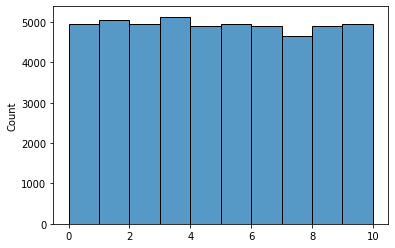

In [19]:
sns.histplot(y, bins=[i for i in range(11)])


### training augment-svm

In [23]:
%%time

import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x = np.array(_x).reshape(-1, 28, 28)
    _x, _y = augment_dataset(_x, _y)
    _x, _y = preprocess(_x, _y)
    
    
    svm = SVC(
        kernel='rbf',
        max_iter=500,
        decision_function_shape='ovr',
        random_state=random_seed,
        verbose=False,
    ) 

    svm.fit(_x, _y)
    
    with open(f'augsvm-{name}', 'wb') as f:
        pickle.dump(svm, f)


  0%|                                                                                                                             | 0/6 [00:00<?, ?it/s]/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 17%|███████████████████▎                                                                                                | 1/6 [02:01<10:07, 121.55s/it]/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 33%|██████████████████████████████████████▋                                                                             | 2/6 [03:30<06:50, 102.55s/it]/Users/navid/miniforge_x86_64/envs/pytorch_x

CPU times: user 14min 27s, sys: 4.12 s, total: 14min 31s
Wall time: 23min 26s


### validate

In [20]:
for model_name in ['augsvm-balanced', 'augsvm-imbalanced', 'augsvm-bal_sym', 'augsvm-bal_asym', 'augsvm-imb_sym', 'augsvm-imb_asym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)
    
    print(model_name)
    y_pred = svm.predict(test_x)
    clf_metrics(test_y, y_pred)

augsvm-balanced
              precision    recall  f1-score   support

           0     0.9808    0.9918    0.9863       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9729    0.9748    0.9739      1032
           3     0.9774    0.9832    0.9803      1010
           4     0.9785    0.9745    0.9765       982
           5     0.9842    0.9787    0.9815       892
           6     0.9843    0.9833    0.9838       958
           7     0.9736    0.9679    0.9707      1028
           8     0.9714    0.9774    0.9744       974
           9     0.9719    0.9594    0.9656      1009

    accuracy                         0.9784     10000
   macro avg     0.9784    0.9783    0.9783     10000
weighted avg     0.9784    0.9784    0.9784     10000

augsvm-imbalanced
              precision    recall  f1-score   support

           0     0.9876    0.9755    0.9815       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9557    0.9816    0.9685 

### training on all datasets

In [38]:
%%time

import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    
    _x, reducer = encode_dataset(_x)
    
    svm = SVC(
        kernel='rbf',
        decision_function_shape='ovr',
        random_state=random_seed,
        verbose=False,
    ) 

    svm.fit(_x, _y)
    
    with open(f'esvm-{name}', 'wb') as f:
        pickle.dump(svm, f)
        
    with open(f'esvm-{name}-encoder', 'wb') as f:
        pickle.dump(reducer, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:52<00:00, 52.76s/it]

CPU times: user 1min 29s, sys: 51 s, total: 2min 20s
Wall time: 52.8 s


### validate

In [37]:
#for model_name in ['esvm-balanced', 'esvm-imbalanced', 'esvm-bal_sym', 'esvm-bal_asym', 'esvm-imb_sym', 'esvm-imb_asym']:
for model_name in ['esvm-bal_sym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)

    with open(f"{model_name}-encoder", 'rb') as f:
        reducer = pickle.load(f)
        
    print(model_name)
    encode_x = encode_dataset(test_x, reducer)[0]
    y_pred = svm.predict(encode_x)
    clf_metrics(test_y, y_pred)

esvm-bal_sym
              precision    recall  f1-score   support

           0     0.9612    0.9857    0.9733       980
           1     0.9285    0.9947    0.9604      1135
           2     0.9835    0.9264    0.9541      1032
           3     0.9630    0.9525    0.9577      1010
           4     0.9694    0.9348    0.9518       982
           5     0.9479    0.9585    0.9532       892
           6     0.9572    0.9812    0.9691       958
           7     0.9402    0.9484    0.9443      1028
           8     0.9803    0.9189    0.9486       974
           9     0.9299    0.9465    0.9381      1009

    accuracy                         0.9551     10000
   macro avg     0.9561    0.9548    0.9551     10000
weighted avg     0.9557    0.9551    0.9550     10000



## Logistic Regression on pytorch

### Model definition

In [ ]:
input_features = train_x[0].shape[1]
output_features = 10
num_epochs = 1

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_input_features, output_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_input_features, output_features)

    def forward(self, x):
        y_predicted = self.linear(x)
        return y_predicted


model = LogisticRegression(input_features * input_features, output_features)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


### Training the logistic regression model


In [ ]:
iter = 5

for epoch in range(num_epochs):
    for batch_number, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_features *
                             input_features).requires_grad_()
        labels = labels
         # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
         # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        batch_number += 1

## Testing the logistic regression model

In [ ]:
predictions = []
real_classes = []

for images, labels in test_loader:
    # Load images to a Torch Variable
    images = images.view(-1, 28*28).requires_grad_()

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.tolist()
    labels = labels.tolist()
    predictions.append(predicted)
    real_classes.append(labels)

predictions = [item for sublist in predictions for item in sublist]
real_classes = [item for sublist in real_classes for item in sublist]

### Confusion matrix and predictions for Logistic regression

In [ ]:
conf_mat(real_classes,predictions)
clf_metrics(real_classes,predictions)

### Saving the model

In [ ]:
torch.save(model.state_dict(), 'models/logistic.pkl')

## LDAM

In [76]:
from collections import Counter


def class_counter(data_loader):
    c = Counter()
    for _, batch_label in data_loader:
        c.update([int(x) for x in batch_label.numpy()])
    
    clist = [0]*10
    
    for cls, cnt in c.items():
        clist[cls] = cnt
        
    return clist

cls_num_list = class_counter(train_loader)

### define components

In [93]:
from resnet import resnet20, resnet32
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F


class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        #m_list = torch.tensor(m_list, dtype=torch.float)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        #index_float = torch.tensor(index, dtype=torch.float)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cls_num_list, device)
learning_rate = 1e-4
model = resnet32()
model.to(device)
criterion = LDAMLoss(cls_num_list)
criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=0.9,
                                weight_decay=2e-4)

[1325, 1956, 3091, 3126, 4381, 2237, 3444, 2315, 5916, 4436] cuda


### training 

In [ ]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    epoch = epoch + 1
    if epoch <= 5:
        lr = lr * epoch / 5
    elif epoch > 180:
        lr = lr * 0.0001
    elif epoch > 160:
        lr = lr * 0.01
    else:
        lr = lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def train_ldam(model, criterion, optimizer, train_loader, valid_loader, num_epochs, lr=0.1, verbose=1, model_prefix='balanced-ldam'):
    
    log(f"{datetime.now()}: training ldam on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        adjust_learning_rate(optimizer, epoch, lr)
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
train_ldam(model, criterion, optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


### training on different datasets

In [ ]:
datasets = [
    (bal_train_loader, bal_valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cls_num_list = class_counter(train_loader)
    log(cls_num_list, device)
    learning_rate = 1e-4
    model = resnet32()
    model.to(device)
    criterion = LDAMLoss(cls_num_list)
    criterion.to(device)
    optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=0.9,
                                weight_decay=2e-4)
    train_ldam(model, criterion, optimizer, train_loader, valid_loader, verbose=5, num_epochs=100,
               model_prefix=f"ldam-{name}")
    

[4965, 5652, 4929, 5119, 4856, 4563, 4915, 5162, 4893, 4946]
2021-12-01 11:55:07.449357: training ldam on ldam-balanced


391it [00:14, 27.08it/s]


epoch 1, training loss: 65.8728256225586


391it [00:14, 27.39it/s]


epoch 2, training loss: 59.03557205200195


391it [00:14, 27.67it/s]


epoch 3, training loss: 115.76194763183594


391it [00:14, 27.65it/s]


epoch 4, training loss: 139.927490234375


391it [00:14, 27.24it/s]


epoch 5, training loss: 140.29441833496094


100%|██████████| 391/391 [00:08<00:00, 45.18it/s]


training loss: 129.3938446044922, train accuracy: 0.09848
validation loss: 128.3618621826172, validation accuracy: 0.1028
saving best model: ldam-balanced-5


391it [00:14, 27.63it/s]


epoch 6, training loss: 139.60809326171875


391it [00:14, 27.69it/s]


epoch 7, training loss: 94.68280792236328


391it [00:13, 28.20it/s]


epoch 8, training loss: 21.681344985961914


391it [00:13, 28.32it/s]


epoch 9, training loss: 4.327630996704102


391it [00:13, 28.30it/s]


epoch 10, training loss: 2.1319923400878906


100%|██████████| 391/391 [00:08<00:00, 44.58it/s]


training loss: 1.82845938205719, train accuracy: 0.95986
validation loss: 2.1644480228424072, validation accuracy: 0.9533
saving best model: ldam-balanced-10


391it [00:13, 28.19it/s]


epoch 11, training loss: 1.5703125


391it [00:13, 28.26it/s]


epoch 12, training loss: 1.4138295650482178


391it [00:13, 28.16it/s]


epoch 13, training loss: 1.065158486366272


391it [00:14, 27.83it/s]


epoch 14, training loss: 1.1000956296920776


391it [00:13, 28.14it/s]


epoch 15, training loss: 1.0139529705047607


100%|██████████| 391/391 [00:08<00:00, 45.21it/s]


training loss: 1.6755845546722412, train accuracy: 0.96156
validation loss: 1.8151624202728271, validation accuracy: 0.959
saving best model: ldam-balanced-15


391it [00:13, 28.27it/s]


epoch 16, training loss: 1.0546760559082031


282it [00:10, 28.41it/s]

### load best model and test

In [14]:
def load_model(path):
    model = resnet32()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


model = load_model(os.path.join('models', 'balanced-70'))
model

ResNet_s(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [18]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

preds, y_true, loss = evaluate(test_loader, model)

100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


### model report

In [90]:
def report(model_name):
    print("model:", model_name)
    model = load_model(os.path.join('models', model_name))
    preds, y_true, loss = evaluate(test_loader, model)
    clf_metrics(y_true, preds)

In [92]:
report('ldam-balanced-95')
# report('ldam-imbalanced-70')
# report('ldam-imb_sym-10')
# report('ldam-imb_asym-5')
# report('ldam-bal_sym-5')
# report('ldam-bal_asym-5')

model: ldam-balanced-95


FileNotFoundError: [Errno 2] No such file or directory: 'models/ldam-balanced-95'

# SCE

## defining components

In [30]:
import torch.nn as nn
import torch.nn.functional as F


class ConvBrunch(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super(ConvBrunch, self).__init__()
        padding = (kernel_size - 1) // 2
        self.out_conv = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_planes),
            nn.ReLU())

    def forward(self, x):
        return self.out_conv(x)


class SCEModel(nn.Module):
    def __init__(self):
        super(SCEModel, self).__init__()
        self.block1 = nn.Sequential(
            ConvBrunch(1, 64, 3),
            ConvBrunch(64, 64, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2 = nn.Sequential(
            ConvBrunch(64, 128, 3),
            ConvBrunch(128, 128, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3 = nn.Sequential(
            ConvBrunch(128, 196, 3),
            ConvBrunch(196, 196, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Linear(1764, 256),
            nn.BatchNorm1d(256),
            nn.ReLU())
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        # x = self.global_avg_pool(x)
        x = x.view(-1, 1764)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


## defining loss function

In [32]:
class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        # CCE
        ce = self.cross_entropy(pred, labels)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

        # Loss
        loss = self.alpha * ce + self.beta * rce.mean()
        return loss
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
sce_model = SCEModel()
sce_model.to(device)
sce_criterion = SCELoss(alpha=0.1, beta=1.0)
sce_criterion.to(device)
sce_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## training 

In [86]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

        
def train_sce(model, criterion, optimizer, train_loader, valid_loader, num_epochs, verbose=1, model_prefix='balanced_sce'):
    
    log(f"{datetime.now()}: training sce on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
#train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


## train on all datasets

In [88]:
datasets = [
    (train_loader, valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4
    sce_model = SCEModel()
    sce_model.to(device)
    sce_criterion = SCELoss(alpha=0.1, beta=1.0)
    sce_criterion.to(device)
    sce_optimizer = torch.optim.Adam(sce_model.parameters(), lr=learning_rate)
    train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=100,
               model_prefix=f"sce-{name}")
    

2021-11-30 21:56:55.998591: training sce on sce-balanced


252it [00:01, 132.32it/s]


epoch 1, training loss: 2.6504039764404297


252it [00:01, 135.32it/s]


epoch 2, training loss: 1.7308382987976074


252it [00:01, 136.85it/s]


epoch 3, training loss: 1.6207009553909302


252it [00:01, 136.19it/s]


epoch 4, training loss: 1.5712660551071167


252it [00:01, 136.88it/s]


epoch 5, training loss: 1.543624997138977


100%|██████████| 252/252 [00:00<00:00, 385.93it/s]


training loss: 1.5167022943496704, train accuracy: 0.8472398920160115
validation loss: 1.4754616022109985, validation accuracy: 0.8541899441340782
saving best model: sce-balanced-5


252it [00:01, 136.05it/s]


epoch 6, training loss: 1.5258822441101074


252it [00:01, 136.56it/s]


epoch 7, training loss: 1.5070571899414062


252it [00:01, 136.33it/s]


epoch 8, training loss: 1.4831078052520752


252it [00:01, 137.11it/s]


epoch 9, training loss: 1.469217300415039


252it [00:01, 136.28it/s]


epoch 10, training loss: 1.4442259073257446


100%|██████████| 252/252 [00:00<00:00, 386.82it/s]


training loss: 1.3812077045440674, train accuracy: 0.861389518105936
validation loss: 1.5441255569458008, validation accuracy: 0.8458100558659218


252it [00:01, 137.06it/s]


epoch 11, training loss: 1.414228081703186


252it [00:01, 135.52it/s]


epoch 12, training loss: 1.3805973529815674


252it [00:01, 136.25it/s]


epoch 13, training loss: 1.3352322578430176


252it [00:01, 136.77it/s]


epoch 14, training loss: 1.2942564487457275


252it [00:01, 137.68it/s]


epoch 15, training loss: 1.243958830833435


100%|██████████| 252/252 [00:00<00:00, 389.82it/s]


training loss: 1.1402982473373413, train accuracy: 0.8877338877338877
validation loss: 1.702967882156372, validation accuracy: 0.8301675977653631


252it [00:01, 136.77it/s]


epoch 16, training loss: 1.203803300857544


252it [00:01, 137.82it/s]


epoch 17, training loss: 1.1533221006393433


252it [00:01, 142.60it/s]


epoch 18, training loss: 1.113701343536377


252it [00:01, 142.32it/s]


epoch 19, training loss: 1.073592185974121


252it [00:01, 137.18it/s]


epoch 20, training loss: 1.029803991317749


100%|██████████| 252/252 [00:00<00:00, 380.46it/s]


training loss: 0.9480012059211731, train accuracy: 0.907593012070624
validation loss: 1.7899154424667358, validation accuracy: 0.8201117318435754


252it [00:01, 136.09it/s]


epoch 21, training loss: 0.9696616530418396


252it [00:01, 135.61it/s]


epoch 22, training loss: 0.9549485445022583


252it [00:01, 135.59it/s]


epoch 23, training loss: 0.9195381999015808


252it [00:01, 135.91it/s]


epoch 24, training loss: 0.9017449021339417


252it [00:01, 135.02it/s]


epoch 25, training loss: 0.8651062250137329


100%|██████████| 252/252 [00:00<00:00, 383.18it/s]


training loss: 0.7955367565155029, train accuracy: 0.9215874887516678
validation loss: 1.7963874340057373, validation accuracy: 0.8206703910614526


252it [00:01, 135.27it/s]


epoch 26, training loss: 0.8533318042755127


252it [00:01, 134.99it/s]


epoch 27, training loss: 0.834099531173706


252it [00:01, 135.58it/s]


epoch 28, training loss: 0.8295735716819763


252it [00:01, 134.90it/s]


epoch 29, training loss: 0.8083573579788208


252it [00:01, 135.58it/s]


epoch 30, training loss: 0.7944598197937012


100%|██████████| 252/252 [00:00<00:00, 383.23it/s]


training loss: 0.7441560626029968, train accuracy: 0.9272969869984795
validation loss: 1.9699615240097046, validation accuracy: 0.8025139664804469


252it [00:01, 135.49it/s]


epoch 31, training loss: 0.7707741260528564


252it [00:01, 137.46it/s]


epoch 32, training loss: 0.7762047648429871


252it [00:01, 136.68it/s]


epoch 33, training loss: 0.7512274980545044


252it [00:01, 137.32it/s]


epoch 34, training loss: 0.7406295537948608


252it [00:01, 137.11it/s]


epoch 35, training loss: 0.7332488894462585


100%|██████████| 252/252 [00:00<00:00, 389.55it/s]


training loss: 0.7224028706550598, train accuracy: 0.9291898097868247
validation loss: 1.919547200202942, validation accuracy: 0.8089385474860336


252it [00:01, 135.51it/s]


epoch 36, training loss: 0.7299472689628601


252it [00:01, 135.30it/s]


epoch 37, training loss: 0.7371657490730286


252it [00:01, 135.21it/s]


epoch 38, training loss: 0.7227480411529541


252it [00:01, 135.94it/s]


epoch 39, training loss: 0.7161478996276855


252it [00:01, 135.06it/s]


epoch 40, training loss: 0.7055249214172363


100%|██████████| 252/252 [00:00<00:00, 384.62it/s]


training loss: 0.664656400680542, train accuracy: 0.9344959195705465
validation loss: 1.8874294757843018, validation accuracy: 0.8114525139664804


252it [00:01, 135.93it/s]


epoch 41, training loss: 0.6972812414169312


252it [00:01, 135.19it/s]


epoch 42, training loss: 0.6897284388542175


252it [00:01, 135.90it/s]


epoch 43, training loss: 0.6948606967926025


252it [00:01, 135.23it/s]


epoch 44, training loss: 0.6870933175086975


252it [00:01, 135.97it/s]


epoch 45, training loss: 0.6871210932731628


100%|██████████| 252/252 [00:00<00:00, 384.50it/s]


training loss: 0.6558879017829895, train accuracy: 0.9353647562602786
validation loss: 1.9059463739395142, validation accuracy: 0.8083798882681564


252it [00:01, 135.20it/s]


epoch 46, training loss: 0.6936360597610474


252it [00:01, 135.99it/s]


epoch 47, training loss: 0.6828854084014893


252it [00:01, 135.09it/s]


epoch 48, training loss: 0.6902734041213989


252it [00:01, 135.66it/s]


epoch 49, training loss: 0.674740731716156


252it [00:01, 135.10it/s]


epoch 50, training loss: 0.6735668778419495


100%|██████████| 252/252 [00:00<00:00, 384.32it/s]


training loss: 0.6500571370124817, train accuracy: 0.9359853538958016
validation loss: 1.9017305374145508, validation accuracy: 0.8083798882681564


252it [00:01, 135.73it/s]


epoch 51, training loss: 0.6763421297073364


252it [00:01, 134.65it/s]


epoch 52, training loss: 0.6656560301780701


252it [00:01, 134.76it/s]


epoch 53, training loss: 0.6708052754402161


252it [00:01, 134.55it/s]


epoch 54, training loss: 0.658674955368042


252it [00:01, 135.07it/s]


epoch 55, training loss: 0.6689059734344482


100%|██████████| 252/252 [00:00<00:00, 374.24it/s]


training loss: 0.6359509229660034, train accuracy: 0.9371334595215193
validation loss: 1.8862640857696533, validation accuracy: 0.8117318435754189


252it [00:01, 134.55it/s]


epoch 56, training loss: 0.6609993577003479


252it [00:01, 135.17it/s]


epoch 57, training loss: 0.6540868878364563


252it [00:01, 134.41it/s]


epoch 58, training loss: 0.6512303352355957


252it [00:01, 134.98it/s]


epoch 59, training loss: 0.6561508774757385


252it [00:01, 135.13it/s]


epoch 60, training loss: 0.6609635353088379


100%|██████████| 252/252 [00:00<00:00, 369.49it/s]


training loss: 0.623222827911377, train accuracy: 0.9381574456201321
validation loss: 1.8833644390106201, validation accuracy: 0.8122905027932961


252it [00:01, 134.91it/s]


epoch 61, training loss: 0.6555545330047607


252it [00:01, 135.22it/s]


epoch 62, training loss: 0.6539958119392395


252it [00:01, 134.58it/s]


epoch 63, training loss: 0.6532998085021973


252it [00:01, 136.12it/s]


epoch 64, training loss: 0.6509063243865967


252it [00:01, 135.57it/s]


epoch 65, training loss: 0.6510745882987976


100%|██████████| 252/252 [00:00<00:00, 379.14it/s]


training loss: 0.6292967796325684, train accuracy: 0.9375989077481615
validation loss: 1.8616255521774292, validation accuracy: 0.8125698324022347


252it [00:01, 136.21it/s]


epoch 66, training loss: 0.6514735817909241


252it [00:01, 135.67it/s]


epoch 67, training loss: 0.640839695930481


252it [00:01, 136.82it/s]


epoch 68, training loss: 0.6361036896705627


252it [00:01, 135.67it/s]


epoch 69, training loss: 0.6457011103630066


252it [00:01, 135.38it/s]


epoch 70, training loss: 0.6514978408813477


100%|██████████| 252/252 [00:00<00:00, 375.31it/s]


training loss: 0.6238427758216858, train accuracy: 0.938343624910789
validation loss: 1.797972559928894, validation accuracy: 0.8195530726256983


252it [00:01, 134.47it/s]


epoch 71, training loss: 0.6354640126228333


252it [00:01, 135.25it/s]


epoch 72, training loss: 0.6281846165657043


252it [00:01, 134.54it/s]


epoch 73, training loss: 0.6218724250793457


252it [00:01, 135.17it/s]


epoch 74, training loss: 0.6342693567276001


252it [00:01, 134.56it/s]


epoch 75, training loss: 0.6356469988822937


100%|██████████| 252/252 [00:00<00:00, 372.25it/s]


training loss: 0.6118043065071106, train accuracy: 0.9392124616005213
validation loss: 1.862611174583435, validation accuracy: 0.8142458100558659


252it [00:01, 134.99it/s]


epoch 76, training loss: 0.6353546977043152


252it [00:01, 134.55it/s]


epoch 77, training loss: 0.635410487651825


252it [00:01, 134.90it/s]


epoch 78, training loss: 0.6413901448249817


252it [00:01, 134.55it/s]


epoch 79, training loss: 0.6376200914382935


252it [00:01, 135.06it/s]


epoch 80, training loss: 0.6318550705909729


100%|██████████| 252/252 [00:00<00:00, 370.28it/s]


training loss: 0.6027640700340271, train accuracy: 0.9399571787631489
validation loss: 1.9308617115020752, validation accuracy: 0.806145251396648


252it [00:01, 134.07it/s]


epoch 81, training loss: 0.6376049518585205


252it [00:01, 135.64it/s]


epoch 82, training loss: 0.6311627626419067


252it [00:01, 135.38it/s]


epoch 83, training loss: 0.6320233941078186


252it [00:01, 135.91it/s]


epoch 84, training loss: 0.6352030634880066


252it [00:01, 135.55it/s]


epoch 85, training loss: 0.6259584426879883


100%|██████████| 252/252 [00:00<00:00, 377.07it/s]


training loss: 0.5985019207000732, train accuracy: 0.9401433580538058
validation loss: 1.8946298360824585, validation accuracy: 0.8111731843575419


252it [00:01, 135.81it/s]


epoch 86, training loss: 0.6188141107559204


252it [00:01, 135.19it/s]


epoch 87, training loss: 0.6153451204299927


252it [00:01, 136.60it/s]


epoch 88, training loss: 0.6170049905776978


252it [00:01, 136.84it/s]


epoch 89, training loss: 0.6146631836891174


252it [00:01, 137.56it/s]


epoch 90, training loss: 0.6213675737380981


100%|██████████| 252/252 [00:00<00:00, 386.56it/s]


training loss: 0.5955376625061035, train accuracy: 0.9403295373444627
validation loss: 1.8746603727340698, validation accuracy: 0.8134078212290503


252it [00:01, 136.29it/s]


epoch 91, training loss: 0.6206927299499512


252it [00:01, 136.79it/s]


epoch 92, training loss: 0.6278239488601685


252it [00:01, 136.78it/s]


epoch 93, training loss: 0.620984673500061


252it [00:01, 136.89it/s]


epoch 94, training loss: 0.6125882863998413


252it [00:01, 136.87it/s]


epoch 95, training loss: 0.6142347455024719


100%|██████████| 252/252 [00:00<00:00, 387.13it/s]


training loss: 0.5920438170433044, train accuracy: 0.9405467465168957
validation loss: 1.9038513898849487, validation accuracy: 0.8106145251396648


252it [00:01, 136.55it/s]


epoch 96, training loss: 0.6144972443580627


252it [00:01, 136.89it/s]


epoch 97, training loss: 0.6176661252975464


252it [00:01, 136.83it/s]


epoch 98, training loss: 0.6233676671981812


252it [00:01, 136.74it/s]


epoch 99, training loss: 0.6283915638923645


252it [00:01, 136.71it/s]


epoch 100, training loss: 0.617298424243927


100%|██████████| 252/252 [00:00<00:00, 382.97it/s]


training loss: 0.5928305387496948, train accuracy: 0.9404846867533435
validation loss: 1.8828283548355103, validation accuracy: 0.8128491620111732
2021-11-30 22:00:17.220195: training sce on sce-imbalanced


252it [00:01, 136.34it/s]


epoch 1, training loss: 1.363159418106079


252it [00:01, 136.83it/s]


epoch 2, training loss: 0.2330298274755478


252it [00:01, 136.50it/s]


epoch 3, training loss: 0.10481327027082443


252it [00:01, 136.37it/s]


epoch 4, training loss: 0.05538972094655037


252it [00:01, 135.17it/s]


epoch 5, training loss: 0.032889094203710556


100%|██████████| 252/252 [00:00<00:00, 381.15it/s]


training loss: 0.01998012699186802, train accuracy: 0.9994104322462531
validation loss: 0.05042549967765808, validation accuracy: 0.9974860335195531
saving best model: sce-imbalanced-5


252it [00:01, 133.46it/s]


epoch 6, training loss: 0.019434958696365356


252it [00:01, 133.01it/s]


epoch 7, training loss: 0.013116816990077496


252it [00:01, 135.04it/s]


epoch 8, training loss: 0.010573042556643486


252it [00:01, 135.09it/s]


epoch 9, training loss: 0.007080865558236837


252it [00:01, 134.92it/s]


epoch 10, training loss: 0.03835119679570198


100%|██████████| 252/252 [00:00<00:00, 382.16it/s]


training loss: 0.06355582922697067, train accuracy: 0.9986036553200732
validation loss: 0.1101008802652359, validation accuracy: 0.9941340782122905


252it [00:01, 135.04it/s]


epoch 11, training loss: 0.04036877676844597


252it [00:01, 135.00it/s]


epoch 12, training loss: 0.01816144585609436


252it [00:01, 134.08it/s]


epoch 13, training loss: 0.007288465742021799


252it [00:01, 135.18it/s]


epoch 14, training loss: 0.006309026852250099


252it [00:01, 135.21it/s]


epoch 15, training loss: 0.004889956675469875


100%|██████████| 252/252 [00:00<00:00, 382.29it/s]


training loss: 0.003950139973312616, train accuracy: 0.9997827908275669
validation loss: 0.02805382013320923, validation accuracy: 0.9977653631284916
saving best model: sce-imbalanced-15


252it [00:01, 133.85it/s]


epoch 16, training loss: 0.003118691500276327


252it [00:01, 135.11it/s]


epoch 17, training loss: 0.002374839037656784


252it [00:01, 134.94it/s]


epoch 18, training loss: 0.0020774933509528637


252it [00:01, 133.93it/s]


epoch 19, training loss: 0.024258453398942947


252it [00:01, 136.12it/s]


epoch 20, training loss: 0.028026485815644264


100%|██████████| 252/252 [00:00<00:00, 381.67it/s]


training loss: 0.0070305862464010715, train accuracy: 0.9998758804728954
validation loss: 0.027448410168290138, validation accuracy: 0.9983240223463687
saving best model: sce-imbalanced-20


252it [00:01, 135.22it/s]


epoch 21, training loss: 0.009929471649229527


252it [00:01, 133.17it/s]


epoch 22, training loss: 0.0030304999090731144


252it [00:01, 135.49it/s]


epoch 23, training loss: 0.0018554687267169356


252it [00:01, 135.49it/s]


epoch 24, training loss: 0.001405552844516933


252it [00:01, 135.36it/s]


epoch 25, training loss: 0.0010551390005275607


100%|██████████| 252/252 [00:00<00:00, 375.03it/s]


training loss: 0.0012009844649583101, train accuracy: 0.9999069103546715
validation loss: 0.019928697496652603, validation accuracy: 0.9980446927374301
saving best model: sce-imbalanced-25


252it [00:01, 133.84it/s]


epoch 26, training loss: 0.001318628084845841


252it [00:01, 134.39it/s]


epoch 27, training loss: 0.0009330181055702269


252it [00:01, 134.17it/s]


epoch 28, training loss: 0.012252293527126312


252it [00:01, 133.05it/s]


epoch 29, training loss: 0.026812231168150902


252it [00:01, 134.19it/s]


epoch 30, training loss: 0.013381806202232838


100%|██████████| 252/252 [00:00<00:00, 380.29it/s]


training loss: 0.039339158684015274, train accuracy: 0.9971452508765941
validation loss: 0.0802096277475357, validation accuracy: 0.9932960893854749


252it [00:01, 134.28it/s]


epoch 31, training loss: 0.005494616460055113


252it [00:01, 133.15it/s]


epoch 32, training loss: 0.0019324144814163446


252it [00:01, 134.13it/s]


epoch 33, training loss: 0.0016266807215288281


252it [00:01, 134.25it/s]


epoch 34, training loss: 0.0009267364512197673


252it [00:01, 133.53it/s]


epoch 35, training loss: 0.0008412898750975728


100%|██████████| 252/252 [00:00<00:00, 377.54it/s]


training loss: 0.0007393316482193768, train accuracy: 0.9999379402364477
validation loss: 0.025381196290254593, validation accuracy: 0.9977653631284916


252it [00:01, 134.19it/s]


epoch 36, training loss: 0.0008135075913742185


252it [00:01, 134.27it/s]


epoch 37, training loss: 0.0007987981662154198


252it [00:01, 133.91it/s]


epoch 38, training loss: 0.0007673790096305311


252it [00:01, 133.30it/s]


epoch 39, training loss: 0.00045498230610974133


252it [00:01, 134.26it/s]


epoch 40, training loss: 0.00042096347897313535


100%|██████████| 252/252 [00:00<00:00, 380.19it/s]


training loss: 0.0003677417116705328, train accuracy: 0.9999689701182238
validation loss: 0.024407031014561653, validation accuracy: 0.9977653631284916


252it [00:01, 134.08it/s]


epoch 41, training loss: 0.0004101450031157583


252it [00:01, 133.12it/s]


epoch 42, training loss: 0.0004007974930573255


252it [00:01, 134.30it/s]


epoch 43, training loss: 0.00038284360198304057


252it [00:01, 134.18it/s]


epoch 44, training loss: 0.00037789129419252276


252it [00:01, 133.19it/s]


epoch 45, training loss: 0.0003585273225326091


100%|██████████| 252/252 [00:00<00:00, 380.99it/s]


training loss: 0.00014607571938540787, train accuracy: 1.0
validation loss: 0.023993417620658875, validation accuracy: 0.9977653631284916


252it [00:01, 134.32it/s]


epoch 46, training loss: 0.005568273831158876


252it [00:01, 134.29it/s]


epoch 47, training loss: 0.05630350857973099


252it [00:01, 135.02it/s]


epoch 48, training loss: 0.011584808118641376


252it [00:01, 142.20it/s]


epoch 49, training loss: 0.004278778564184904


252it [00:01, 142.56it/s]


epoch 50, training loss: 0.002486311597749591


100%|██████████| 252/252 [00:00<00:00, 389.15it/s]


training loss: 0.0028192210011184216, train accuracy: 0.9997827908275669
validation loss: 0.023437703028321266, validation accuracy: 0.9980446927374301


252it [00:01, 135.04it/s]


epoch 51, training loss: 0.002786970464512706


252it [00:01, 135.22it/s]


epoch 52, training loss: 0.0018529606750234962


252it [00:01, 135.51it/s]


epoch 53, training loss: 0.0008767663384787738


252it [00:01, 135.45it/s]


epoch 54, training loss: 0.0007654241635464132


252it [00:01, 133.90it/s]


epoch 55, training loss: 0.0007330329972319305


100%|██████████| 252/252 [00:00<00:00, 384.92it/s]


training loss: 0.0005776071920990944, train accuracy: 0.9999379402364477
validation loss: 0.019345268607139587, validation accuracy: 0.9983240223463687
saving best model: sce-imbalanced-55


252it [00:01, 136.04it/s]


epoch 56, training loss: 0.0007356659043580294


252it [00:01, 136.20it/s]


epoch 57, training loss: 0.00042258950998075306


252it [00:01, 136.42it/s]


epoch 58, training loss: 0.0003854271781165153


252it [00:01, 135.71it/s]


epoch 59, training loss: 0.0003992368874605745


252it [00:01, 136.33it/s]


epoch 60, training loss: 0.016712499782443047


100%|██████████| 252/252 [00:00<00:00, 383.64it/s]


training loss: 0.01717210002243519, train accuracy: 0.9989449840196108
validation loss: 0.04908580332994461, validation accuracy: 0.9955307262569832


252it [00:01, 137.15it/s]


epoch 61, training loss: 0.013072315603494644


252it [00:01, 137.40it/s]


epoch 62, training loss: 0.007944990880787373


252it [00:01, 137.59it/s]


epoch 63, training loss: 0.002822806593030691


252it [00:01, 135.48it/s]


epoch 96, training loss: 1.168840299214935e-05


252it [00:01, 134.49it/s]


epoch 97, training loss: 1.1471011930552777e-05


252it [00:01, 134.04it/s]


epoch 98, training loss: 1.0956100595649332e-05


252it [00:01, 134.64it/s]


epoch 99, training loss: 1.0790443411679007e-05


252it [00:01, 134.09it/s]


epoch 100, training loss: 1.0618417945806868e-05


100%|██████████| 252/252 [00:00<00:00, 379.17it/s]


training loss: 8.83064330992056e-06, train accuracy: 1.0
validation loss: 0.01973225735127926, validation accuracy: 0.9980446927374301
2021-11-30 22:03:38.769941: training sce on sce-bal_sym


352it [00:02, 134.42it/s]


epoch 1, training loss: 3.4794068336486816


352it [00:02, 134.78it/s]


epoch 2, training loss: 2.8564224243164062


352it [00:02, 135.38it/s]


epoch 3, training loss: 2.799910545349121


352it [00:02, 135.48it/s]


epoch 4, training loss: 2.7727701663970947


352it [00:02, 134.56it/s]


epoch 5, training loss: 2.7574374675750732


100%|██████████| 352/352 [00:00<00:00, 378.05it/s]


training loss: 2.734945058822632, train accuracy: 0.7311333333333333
validation loss: 2.8051393032073975, validation accuracy: 0.7254
saving best model: sce-bal_sym-5


352it [00:02, 134.25it/s]


epoch 6, training loss: 2.7385778427124023


352it [00:02, 141.24it/s]


epoch 7, training loss: 2.727094888687134


352it [00:02, 138.26it/s]


epoch 8, training loss: 2.716001033782959


352it [00:02, 140.81it/s]


epoch 9, training loss: 2.70489501953125


352it [00:02, 142.11it/s]


epoch 10, training loss: 2.7046210765838623


100%|██████████| 352/352 [00:00<00:00, 371.55it/s]


training loss: 2.695542812347412, train accuracy: 0.7351777777777778
validation loss: 2.8351967334747314, validation accuracy: 0.7232


352it [00:02, 133.58it/s]


epoch 11, training loss: 2.6866753101348877


352it [00:02, 135.59it/s]


epoch 12, training loss: 2.6682066917419434


352it [00:02, 135.58it/s]


epoch 13, training loss: 2.6600875854492188


352it [00:02, 134.18it/s]


epoch 14, training loss: 2.6430482864379883


352it [00:02, 134.71it/s]


epoch 15, training loss: 2.6261484622955322


100%|██████████| 352/352 [00:00<00:00, 376.38it/s]


training loss: 2.5916483402252197, train accuracy: 0.7436444444444444
validation loss: 2.8890254497528076, validation accuracy: 0.7208


352it [00:02, 135.01it/s]


epoch 16, training loss: 2.6067140102386475


352it [00:02, 135.38it/s]


epoch 17, training loss: 2.57827091217041


352it [00:02, 133.58it/s]


epoch 18, training loss: 2.5469319820404053


352it [00:02, 135.58it/s]


epoch 19, training loss: 2.521820306777954


352it [00:02, 138.47it/s]


epoch 20, training loss: 2.485002040863037


100%|██████████| 352/352 [00:00<00:00, 378.93it/s]


training loss: 2.4183967113494873, train accuracy: 0.7609333333333334
validation loss: 2.967491865158081, validation accuracy: 0.716


352it [00:02, 140.50it/s]


epoch 21, training loss: 2.4424126148223877


352it [00:02, 141.36it/s]


epoch 22, training loss: 2.3995656967163086


352it [00:02, 142.21it/s]


epoch 23, training loss: 2.354773759841919


352it [00:02, 141.07it/s]


epoch 24, training loss: 2.2940433025360107


352it [00:02, 137.08it/s]


epoch 25, training loss: 2.2455313205718994


100%|██████████| 352/352 [00:00<00:00, 378.35it/s]


training loss: 2.1433420181274414, train accuracy: 0.7888222222222222
validation loss: 3.136803388595581, validation accuracy: 0.7068


352it [00:02, 133.98it/s]


epoch 26, training loss: 2.1677627563476562


352it [00:02, 135.12it/s]


epoch 27, training loss: 2.100811243057251


352it [00:02, 133.93it/s]


epoch 28, training loss: 2.0322742462158203


352it [00:02, 134.92it/s]


epoch 29, training loss: 1.971923828125


352it [00:02, 134.84it/s]


epoch 30, training loss: 1.8840720653533936


100%|██████████| 352/352 [00:00<00:00, 376.36it/s]


training loss: 1.7678196430206299, train accuracy: 0.8278888888888889
validation loss: 3.3773627281188965, validation accuracy: 0.6846


352it [00:02, 135.31it/s]


epoch 31, training loss: 1.8139710426330566


352it [00:02, 134.55it/s]


epoch 32, training loss: 1.7468407154083252


352it [00:02, 132.96it/s]


epoch 33, training loss: 1.6933926343917847


352it [00:02, 133.95it/s]


epoch 34, training loss: 1.6103817224502563


352it [00:02, 136.14it/s]


epoch 35, training loss: 1.543666958808899


100%|██████████| 352/352 [00:00<00:00, 381.10it/s]


training loss: 1.4445958137512207, train accuracy: 0.8605333333333334
validation loss: 3.4844462871551514, validation accuracy: 0.6688


352it [00:02, 131.49it/s]


epoch 36, training loss: 1.4942363500595093


352it [00:02, 134.60it/s]


epoch 37, training loss: 1.433982014656067


352it [00:02, 132.81it/s]


epoch 38, training loss: 1.3741405010223389


352it [00:02, 134.76it/s]


epoch 39, training loss: 1.3268694877624512


352it [00:02, 134.38it/s]


epoch 40, training loss: 1.2715705633163452


100%|██████████| 352/352 [00:00<00:00, 380.44it/s]


training loss: 1.1705331802368164, train accuracy: 0.8871555555555556
validation loss: 3.5833563804626465, validation accuracy: 0.6634


352it [00:02, 134.10it/s]


epoch 41, training loss: 1.2143515348434448


352it [00:02, 135.05it/s]


epoch 42, training loss: 1.1749110221862793


352it [00:02, 132.49it/s]


epoch 43, training loss: 1.1341443061828613


352it [00:02, 136.87it/s]


epoch 44, training loss: 1.0908164978027344


352it [00:02, 137.85it/s]


epoch 45, training loss: 1.0406990051269531


100%|██████████| 352/352 [00:00<00:00, 371.92it/s]


training loss: 0.9729442596435547, train accuracy: 0.9079555555555555
validation loss: 3.6240310668945312, validation accuracy: 0.6584


352it [00:02, 135.39it/s]


epoch 46, training loss: 1.0063437223434448


352it [00:02, 135.23it/s]


epoch 47, training loss: 0.9621970653533936


352it [00:02, 136.04it/s]


epoch 48, training loss: 0.9387348294258118


352it [00:02, 135.96it/s]


epoch 49, training loss: 0.8860727548599243


352it [00:02, 136.74it/s]


epoch 50, training loss: 0.8449182510375977


100%|██████████| 352/352 [00:00<00:00, 392.11it/s]


training loss: 0.8164951801300049, train accuracy: 0.9241333333333334
validation loss: 3.8559303283691406, validation accuracy: 0.6308


352it [00:02, 137.47it/s]


epoch 51, training loss: 0.8239737153053284


352it [00:02, 138.40it/s]


epoch 52, training loss: 0.8085874915122986


352it [00:02, 140.19it/s]


epoch 53, training loss: 0.7590163946151733


352it [00:02, 142.56it/s]


epoch 54, training loss: 0.7421169877052307


352it [00:02, 145.15it/s]


epoch 55, training loss: 0.7234850525856018


100%|██████████| 352/352 [00:00<00:00, 395.88it/s]


training loss: 0.6495609283447266, train accuracy: 0.9396222222222222
validation loss: 3.927963972091675, validation accuracy: 0.6344


352it [00:02, 145.41it/s]


epoch 56, training loss: 0.6866884827613831


352it [00:02, 144.96it/s]


epoch 57, training loss: 0.6500157713890076


352it [00:02, 144.73it/s]


epoch 58, training loss: 0.6210623979568481


352it [00:02, 144.95it/s]


epoch 59, training loss: 0.6096896529197693


352it [00:02, 145.13it/s]


epoch 60, training loss: 0.5990195870399475


100%|██████████| 352/352 [00:00<00:00, 394.76it/s]


training loss: 0.5389643311500549, train accuracy: 0.9497777777777778
validation loss: 3.818028688430786, validation accuracy: 0.6498


352it [00:02, 144.33it/s]


epoch 61, training loss: 0.5783929228782654


352it [00:02, 143.76it/s]


epoch 62, training loss: 0.5408087372779846


352it [00:02, 144.26it/s]


epoch 63, training loss: 0.5297500491142273


352it [00:02, 143.68it/s]


epoch 64, training loss: 0.5161036849021912


352it [00:02, 143.78it/s]


epoch 65, training loss: 0.5027157068252563


100%|██████████| 352/352 [00:00<00:00, 388.06it/s]


training loss: 0.4621295630931854, train accuracy: 0.9574888888888888
validation loss: 3.980935573577881, validation accuracy: 0.6268


352it [00:02, 137.57it/s]


epoch 66, training loss: 0.48724600672721863


352it [00:02, 136.38it/s]


epoch 67, training loss: 0.4652528464794159


352it [00:02, 135.49it/s]


epoch 68, training loss: 0.45136040449142456


352it [00:02, 135.67it/s]


epoch 69, training loss: 0.4465970993041992


352it [00:02, 134.83it/s]


epoch 70, training loss: 0.4356699287891388


100%|██████████| 352/352 [00:00<00:00, 375.69it/s]


training loss: 0.39919808506965637, train accuracy: 0.9641111111111111
validation loss: 4.021876335144043, validation accuracy: 0.6246


352it [00:02, 134.21it/s]


epoch 71, training loss: 0.4122062921524048


352it [00:02, 133.92it/s]


epoch 72, training loss: 0.41403916478157043


352it [00:02, 134.04it/s]


epoch 73, training loss: 0.4030892550945282


352it [00:02, 130.60it/s]


epoch 74, training loss: 0.37275925278663635


352it [00:02, 134.54it/s]


epoch 75, training loss: 0.35586997866630554


100%|██████████| 352/352 [00:00<00:00, 360.32it/s]


training loss: 0.3246835768222809, train accuracy: 0.9708222222222223
validation loss: 3.880497694015503, validation accuracy: 0.6326


352it [00:02, 133.24it/s]


epoch 76, training loss: 0.35292860865592957


352it [00:02, 135.66it/s]


epoch 77, training loss: 0.3442019522190094


352it [00:02, 135.31it/s]


epoch 78, training loss: 0.3224564790725708


352it [00:02, 135.48it/s]


epoch 79, training loss: 0.3006752133369446


352it [00:02, 135.57it/s]


epoch 80, training loss: 0.2976684272289276


100%|██████████| 352/352 [00:00<00:00, 375.39it/s]


training loss: 0.3077314496040344, train accuracy: 0.9724444444444444
validation loss: 4.0962419509887695, validation accuracy: 0.622


352it [00:02, 135.69it/s]


epoch 81, training loss: 0.3097301721572876


352it [00:02, 134.24it/s]


epoch 82, training loss: 0.3007931411266327


352it [00:02, 134.07it/s]


epoch 83, training loss: 0.29983285069465637


352it [00:02, 135.06it/s]


epoch 84, training loss: 0.28144070506095886


352it [00:02, 135.08it/s]


epoch 85, training loss: 0.2668093740940094


100%|██████████| 352/352 [00:00<00:00, 371.79it/s]


training loss: 0.22562971711158752, train accuracy: 0.9797111111111111
validation loss: 3.936297655105591, validation accuracy: 0.635


352it [00:02, 134.84it/s]


epoch 86, training loss: 0.2627095878124237


352it [00:02, 134.82it/s]


epoch 87, training loss: 0.26242363452911377


352it [00:02, 135.18it/s]


epoch 88, training loss: 0.24607990682125092


352it [00:02, 136.17it/s]


epoch 89, training loss: 0.24350565671920776


352it [00:02, 136.74it/s]


epoch 90, training loss: 0.23057673871517181


100%|██████████| 352/352 [00:00<00:00, 370.41it/s]


training loss: 0.2041648030281067, train accuracy: 0.9821111111111112
validation loss: 4.160099506378174, validation accuracy: 0.6172


352it [00:02, 135.06it/s]


epoch 91, training loss: 0.22655190527439117


352it [00:02, 134.48it/s]


epoch 92, training loss: 0.24103142321109772


352it [00:02, 134.63it/s]


epoch 93, training loss: 0.23199893534183502


352it [00:02, 135.04it/s]


epoch 94, training loss: 0.20625309646129608


352it [00:02, 136.47it/s]


epoch 95, training loss: 0.2149837166070938


100%|██████████| 352/352 [00:00<00:00, 380.39it/s]


training loss: 0.17138303816318512, train accuracy: 0.9850666666666666
validation loss: 4.036840438842773, validation accuracy: 0.6174


352it [00:02, 136.85it/s]


epoch 96, training loss: 0.19844208657741547


352it [00:02, 136.87it/s]


epoch 97, training loss: 0.19229374825954437


352it [00:02, 136.99it/s]


epoch 98, training loss: 0.2120027095079422


352it [00:02, 136.66it/s]


epoch 99, training loss: 0.1857871413230896


352it [00:02, 137.37it/s]


epoch 100, training loss: 0.17527444660663605


100%|██████████| 352/352 [00:00<00:00, 384.59it/s]


training loss: 0.1493179351091385, train accuracy: 0.9868444444444444
validation loss: 4.111350059509277, validation accuracy: 0.6244
2021-11-30 22:08:18.222643: training sce on sce-bal_asym


352it [00:02, 136.47it/s]


epoch 1, training loss: 2.3349246978759766


352it [00:02, 137.22it/s]


epoch 2, training loss: 1.6198875904083252


352it [00:02, 133.37it/s]


epoch 3, training loss: 1.5494697093963623


352it [00:02, 133.19it/s]


epoch 4, training loss: 1.5133639574050903


352it [00:02, 134.43it/s]


epoch 5, training loss: 1.4895820617675781


100%|██████████| 352/352 [00:00<00:00, 372.04it/s]


training loss: 1.4566307067871094, train accuracy: 0.8532
validation loss: 1.6364730596542358, validation accuracy: 0.8424
saving best model: sce-bal_asym-5


352it [00:02, 134.27it/s]


epoch 6, training loss: 1.473181962966919


352it [00:02, 134.54it/s]


epoch 7, training loss: 1.4598278999328613


352it [00:02, 135.01it/s]


epoch 8, training loss: 1.4425511360168457


352it [00:02, 134.57it/s]


epoch 9, training loss: 1.4201678037643433


352it [00:02, 134.51it/s]


epoch 10, training loss: 1.404419183731079


100%|██████████| 352/352 [00:00<00:00, 372.55it/s]


training loss: 1.334135890007019, train accuracy: 0.8652888888888889
validation loss: 1.682787537574768, validation accuracy: 0.8368


352it [00:02, 134.66it/s]


epoch 11, training loss: 1.3640414476394653


352it [00:02, 134.76it/s]


epoch 12, training loss: 1.335870623588562


352it [00:02, 136.48it/s]


epoch 13, training loss: 1.2924809455871582


352it [00:02, 136.49it/s]


epoch 14, training loss: 1.2305638790130615


352it [00:02, 136.24it/s]


epoch 15, training loss: 1.1772559881210327


100%|██████████| 352/352 [00:00<00:00, 383.91it/s]


training loss: 1.1039990186691284, train accuracy: 0.8910444444444444
validation loss: 1.7805877923965454, validation accuracy: 0.8188


352it [00:02, 136.38it/s]


epoch 16, training loss: 1.1040860414505005


352it [00:02, 137.11it/s]


epoch 17, training loss: 1.0244413614273071


352it [00:02, 137.44it/s]


epoch 18, training loss: 0.939872145652771


352it [00:02, 136.71it/s]


epoch 19, training loss: 0.8801801800727844


352it [00:02, 136.46it/s]


epoch 20, training loss: 0.8145108819007874


100%|██████████| 352/352 [00:00<00:00, 383.31it/s]


training loss: 0.6932332515716553, train accuracy: 0.9332222222222222
validation loss: 1.8802974224090576, validation accuracy: 0.8136


352it [00:02, 135.97it/s]


epoch 21, training loss: 0.7377374768257141


352it [00:02, 137.12it/s]


epoch 22, training loss: 0.6650370955467224


352it [00:02, 136.88it/s]


epoch 23, training loss: 0.596136212348938


352it [00:02, 136.12it/s]


epoch 24, training loss: 0.5495898723602295


352it [00:02, 136.19it/s]


epoch 25, training loss: 0.4994446039199829


100%|██████████| 352/352 [00:00<00:00, 376.42it/s]


training loss: 0.4571128189563751, train accuracy: 0.9571777777777778
validation loss: 2.0198111534118652, validation accuracy: 0.7988


352it [00:02, 135.81it/s]


epoch 26, training loss: 0.4627610146999359


352it [00:02, 136.13it/s]


epoch 27, training loss: 0.4306788742542267


352it [00:02, 135.17it/s]


epoch 28, training loss: 0.38898277282714844


352it [00:02, 135.32it/s]


epoch 29, training loss: 0.35261812806129456


352it [00:02, 135.23it/s]


epoch 30, training loss: 0.33635303378105164


100%|██████████| 352/352 [00:00<00:00, 373.92it/s]


training loss: 0.3196033239364624, train accuracy: 0.9708222222222223
validation loss: 2.13257098197937, validation accuracy: 0.7868


352it [00:02, 135.10it/s]


epoch 31, training loss: 0.3137495815753937


352it [00:02, 135.35it/s]


epoch 32, training loss: 0.2830394506454468


352it [00:02, 136.13it/s]


epoch 33, training loss: 0.27857568860054016


352it [00:02, 136.11it/s]


epoch 34, training loss: 0.2394627034664154


352it [00:02, 135.97it/s]


epoch 35, training loss: 0.22179915010929108


100%|██████████| 352/352 [00:00<00:00, 377.97it/s]


training loss: 0.18046355247497559, train accuracy: 0.9835555555555555
validation loss: 2.025282382965088, validation accuracy: 0.7964


352it [00:02, 135.96it/s]


epoch 36, training loss: 0.21786926686763763


352it [00:02, 136.04it/s]


epoch 37, training loss: 0.1972547173500061


352it [00:02, 135.72it/s]


epoch 38, training loss: 0.1868266612291336


352it [00:02, 135.07it/s]


epoch 39, training loss: 0.17514890432357788


352it [00:02, 134.87it/s]


epoch 40, training loss: 0.1828118860721588


100%|██████████| 352/352 [00:00<00:00, 372.34it/s]


training loss: 0.15470387041568756, train accuracy: 0.9863555555555555
validation loss: 2.0911145210266113, validation accuracy: 0.7896


352it [00:02, 133.02it/s]


epoch 41, training loss: 0.18408150970935822


352it [00:02, 134.92it/s]


epoch 42, training loss: 0.14645090699195862


352it [00:02, 135.46it/s]


epoch 43, training loss: 0.1501912921667099


352it [00:02, 134.89it/s]


epoch 44, training loss: 0.1507321447134018


352it [00:02, 135.46it/s]


epoch 45, training loss: 0.14419005811214447


100%|██████████| 352/352 [00:00<00:00, 373.55it/s]


training loss: 0.1612357348203659, train accuracy: 0.9857555555555556
validation loss: 2.2499890327453613, validation accuracy: 0.7786


352it [00:02, 135.20it/s]


epoch 46, training loss: 0.1341465413570404


352it [00:02, 134.97it/s]


epoch 47, training loss: 0.12892113626003265


352it [00:02, 135.91it/s]


epoch 48, training loss: 0.11401980370283127


352it [00:02, 134.85it/s]


epoch 49, training loss: 0.12194204330444336


352it [00:02, 134.68it/s]


epoch 50, training loss: 0.12059677392244339


100%|██████████| 352/352 [00:00<00:00, 373.34it/s]


training loss: 0.10242093354463577, train accuracy: 0.991
validation loss: 2.1332740783691406, validation accuracy: 0.7906


352it [00:02, 134.58it/s]


epoch 51, training loss: 0.11684928089380264


352it [00:02, 135.22it/s]


epoch 52, training loss: 0.10644182562828064


352it [00:02, 135.41it/s]


epoch 53, training loss: 0.1030125543475151


352it [00:02, 136.63it/s]


epoch 54, training loss: 0.10221783816814423


352it [00:02, 136.90it/s]


epoch 55, training loss: 0.10294518619775772


100%|██████████| 352/352 [00:00<00:00, 383.22it/s]


training loss: 0.09348208457231522, train accuracy: 0.9917111111111111
validation loss: 2.1177663803100586, validation accuracy: 0.7894


352it [00:02, 136.55it/s]


epoch 56, training loss: 0.09761512279510498


352it [00:02, 137.27it/s]


epoch 57, training loss: 0.09168462455272675


352it [00:02, 136.22it/s]


epoch 58, training loss: 0.07186970114707947


352it [00:02, 136.36it/s]


epoch 59, training loss: 0.09421823173761368


352it [00:02, 136.52it/s]


epoch 60, training loss: 0.10969679057598114


100%|██████████| 352/352 [00:00<00:00, 382.60it/s]


training loss: 0.08675884455442429, train accuracy: 0.9924888888888889
validation loss: 2.1524910926818848, validation accuracy: 0.7814


352it [00:02, 137.22it/s]


epoch 61, training loss: 0.08676259964704514


352it [00:02, 136.16it/s]


epoch 62, training loss: 0.06826698035001755


352it [00:02, 134.42it/s]


epoch 63, training loss: 0.08143710345029831


352it [00:02, 136.18it/s]


epoch 64, training loss: 0.07773271203041077


352it [00:02, 137.03it/s]


epoch 65, training loss: 0.06460690498352051


100%|██████████| 352/352 [00:00<00:00, 384.09it/s]


training loss: 0.05643418803811073, train accuracy: 0.9952
validation loss: 2.2264366149902344, validation accuracy: 0.777


352it [00:02, 136.56it/s]


epoch 66, training loss: 0.05724005401134491


352it [00:02, 136.97it/s]


epoch 67, training loss: 0.060440436005592346


352it [00:02, 136.58it/s]


epoch 68, training loss: 0.06512755900621414


352it [00:02, 137.22it/s]


epoch 69, training loss: 0.07375812530517578


352it [00:02, 136.00it/s]


epoch 70, training loss: 0.07372570782899857


100%|██████████| 352/352 [00:00<00:00, 383.24it/s]


training loss: 0.05356207862496376, train accuracy: 0.9954444444444445
validation loss: 2.1190898418426514, validation accuracy: 0.7906


352it [00:02, 137.05it/s]


epoch 71, training loss: 0.06262591481208801


352it [00:02, 137.11it/s]


epoch 72, training loss: 0.05217568576335907


352it [00:02, 136.46it/s]


epoch 73, training loss: 0.06525766104459763


352it [00:02, 136.09it/s]


epoch 74, training loss: 0.054073356091976166


352it [00:02, 136.49it/s]


epoch 75, training loss: 0.05339841544628143


100%|██████████| 352/352 [00:00<00:00, 384.34it/s]


training loss: 0.04253711923956871, train accuracy: 0.9964
validation loss: 2.1522791385650635, validation accuracy: 0.7934


352it [00:02, 136.42it/s]


epoch 76, training loss: 0.05625003203749657


352it [00:02, 136.43it/s]


epoch 77, training loss: 0.0639943853020668


352it [00:02, 135.91it/s]


epoch 78, training loss: 0.05197624862194061


352it [00:02, 136.30it/s]


epoch 79, training loss: 0.049324825406074524


352it [00:02, 136.13it/s]


epoch 80, training loss: 0.06653464585542679


100%|██████████| 352/352 [00:00<00:00, 377.32it/s]


training loss: 0.05897891893982887, train accuracy: 0.9947555555555555
validation loss: 2.2747409343719482, validation accuracy: 0.7818


352it [00:02, 136.23it/s]


epoch 81, training loss: 0.060888729989528656


352it [00:02, 135.70it/s]


epoch 82, training loss: 0.05241734907031059


352it [00:02, 136.31it/s]


epoch 83, training loss: 0.04739191383123398


352it [00:02, 135.50it/s]


epoch 84, training loss: 0.051113829016685486


352it [00:02, 136.34it/s]


epoch 85, training loss: 0.057332493364810944


100%|██████████| 352/352 [00:00<00:00, 376.58it/s]


training loss: 0.03895840793848038, train accuracy: 0.9966888888888888
validation loss: 2.215405225753784, validation accuracy: 0.7842


352it [00:02, 128.47it/s]


epoch 86, training loss: 0.043080780655145645


352it [00:02, 136.07it/s]


epoch 87, training loss: 0.04099413752555847


352it [00:02, 136.08it/s]


epoch 88, training loss: 0.04428032040596008


352it [00:02, 135.45it/s]


epoch 89, training loss: 0.046611834317445755


352it [00:02, 135.12it/s]


epoch 90, training loss: 0.05861452966928482


100%|██████████| 352/352 [00:00<00:00, 377.21it/s]


training loss: 0.03877339884638786, train accuracy: 0.9964888888888889
validation loss: 2.203258991241455, validation accuracy: 0.7846


352it [00:02, 135.14it/s]


epoch 91, training loss: 0.04489577189087868


352it [00:02, 133.42it/s]


epoch 92, training loss: 0.04096057265996933


352it [00:02, 132.96it/s]


epoch 93, training loss: 0.03862755373120308


352it [00:02, 132.54it/s]


epoch 94, training loss: 0.03519027307629585


352it [00:02, 136.27it/s]


epoch 95, training loss: 0.04443599283695221


100%|██████████| 352/352 [00:00<00:00, 383.00it/s]


training loss: 0.0219638142734766, train accuracy: 0.9983333333333333
validation loss: 2.1727683544158936, validation accuracy: 0.7934


352it [00:02, 136.59it/s]


epoch 96, training loss: 0.040698856115341187


352it [00:02, 136.37it/s]


epoch 97, training loss: 0.04362950101494789


352it [00:02, 136.66it/s]


epoch 98, training loss: 0.035463158041238785


352it [00:02, 136.66it/s]


epoch 99, training loss: 0.05040239170193672


352it [00:02, 136.23it/s]


epoch 100, training loss: 0.04531349241733551


100%|██████████| 352/352 [00:00<00:00, 380.99it/s]


training loss: 0.02651706151664257, train accuracy: 0.9978222222222223
validation loss: 2.1461105346679688, validation accuracy: 0.7876
2021-11-30 22:12:59.540390: training sce on sce-imb_sym


252it [00:01, 136.11it/s]


epoch 1, training loss: 3.667851448059082


252it [00:01, 136.03it/s]


epoch 2, training loss: 2.877591609954834


252it [00:01, 136.19it/s]


epoch 3, training loss: 2.7921879291534424


252it [00:01, 136.38it/s]


epoch 4, training loss: 2.7600064277648926


252it [00:01, 136.29it/s]


epoch 5, training loss: 2.739243268966675


100%|██████████| 252/252 [00:00<00:00, 382.14it/s]


training loss: 2.716498851776123, train accuracy: 0.7308468054736711
validation loss: 2.7355358600616455, validation accuracy: 0.7335195530726257
saving best model: sce-imb_sym-5


252it [00:01, 136.18it/s]


epoch 6, training loss: 2.7306642532348633


252it [00:01, 134.82it/s]


epoch 7, training loss: 2.719045877456665


252it [00:01, 134.91it/s]


epoch 8, training loss: 2.713409900665283


252it [00:01, 135.16it/s]


epoch 9, training loss: 2.6996004581451416


252it [00:01, 135.09it/s]


epoch 10, training loss: 2.685776472091675


100%|██████████| 252/252 [00:00<00:00, 377.28it/s]


training loss: 2.666370153427124, train accuracy: 0.7351909889223323
validation loss: 2.772853136062622, validation accuracy: 0.7301675977653631


252it [00:01, 134.94it/s]


epoch 11, training loss: 2.686736822128296


252it [00:01, 135.12it/s]


epoch 12, training loss: 2.675537586212158


252it [00:01, 134.72it/s]


epoch 13, training loss: 2.6618990898132324


252it [00:01, 135.09it/s]


epoch 14, training loss: 2.649712085723877


252it [00:01, 135.19it/s]


epoch 15, training loss: 2.634047746658325


100%|██████████| 252/252 [00:00<00:00, 376.43it/s]


training loss: 2.601163148880005, train accuracy: 0.7418934433859807
validation loss: 2.8473947048187256, validation accuracy: 0.7268156424581006


252it [00:01, 135.05it/s]


epoch 16, training loss: 2.614593029022217


252it [00:01, 135.14it/s]


epoch 17, training loss: 2.5988526344299316


252it [00:01, 134.80it/s]


epoch 18, training loss: 2.577683687210083


252it [00:01, 135.01it/s]


epoch 19, training loss: 2.558624267578125


252it [00:01, 134.99it/s]


epoch 20, training loss: 2.530874490737915


100%|██████████| 252/252 [00:00<00:00, 376.92it/s]


training loss: 2.4846749305725098, train accuracy: 0.7550811431408446
validation loss: 2.963085412979126, validation accuracy: 0.7153631284916201


252it [00:01, 135.07it/s]


epoch 21, training loss: 2.4963481426239014


252it [00:01, 134.91it/s]


epoch 22, training loss: 2.4646859169006348


252it [00:01, 134.94it/s]


epoch 23, training loss: 2.4385995864868164


252it [00:01, 134.63it/s]


epoch 24, training loss: 2.397690534591675


252it [00:01, 135.02it/s]


epoch 25, training loss: 2.362118721008301


100%|██████████| 252/252 [00:00<00:00, 376.14it/s]


training loss: 2.297171115875244, train accuracy: 0.7733577435069973
validation loss: 3.0474350452423096, validation accuracy: 0.7061452513966481


252it [00:01, 136.46it/s]


epoch 26, training loss: 2.316427230834961


252it [00:01, 136.56it/s]


epoch 27, training loss: 2.279203414916992


252it [00:01, 136.67it/s]


epoch 28, training loss: 2.2479872703552246


252it [00:01, 136.03it/s]


epoch 29, training loss: 2.2054443359375


252it [00:01, 136.47it/s]


epoch 30, training loss: 2.1615190505981445


100%|██████████| 252/252 [00:00<00:00, 384.53it/s]


training loss: 2.08593487739563, train accuracy: 0.7948924814596456
validation loss: 3.2467093467712402, validation accuracy: 0.6918994413407821


252it [00:01, 136.51it/s]


epoch 31, training loss: 2.1236064434051514


252it [00:01, 136.56it/s]


epoch 32, training loss: 2.0851666927337646


252it [00:01, 136.43it/s]


epoch 33, training loss: 2.054464101791382


252it [00:01, 136.21it/s]


epoch 34, training loss: 2.0079824924468994


252it [00:01, 136.05it/s]


epoch 35, training loss: 1.9778379201889038


100%|██████████| 252/252 [00:00<00:00, 383.35it/s]


training loss: 1.9246251583099365, train accuracy: 0.8134793806435597
validation loss: 3.477813482284546, validation accuracy: 0.6701117318435754


252it [00:01, 136.45it/s]


epoch 36, training loss: 1.946028470993042


252it [00:01, 136.51it/s]


epoch 37, training loss: 1.9034065008163452


252it [00:01, 136.39it/s]


epoch 38, training loss: 1.8755004405975342


252it [00:01, 136.60it/s]


epoch 39, training loss: 1.8441944122314453


252it [00:01, 135.93it/s]


epoch 40, training loss: 1.8172394037246704


100%|██████████| 252/252 [00:00<00:00, 375.81it/s]


training loss: 1.746371865272522, train accuracy: 0.8302665466844571
validation loss: 3.536785364151001, validation accuracy: 0.6625698324022347


252it [00:01, 134.90it/s]


epoch 41, training loss: 1.7783583402633667


252it [00:01, 134.97it/s]


epoch 42, training loss: 1.7623802423477173


252it [00:01, 136.40it/s]


epoch 43, training loss: 1.7241945266723633


252it [00:01, 136.42it/s]


epoch 44, training loss: 1.6995749473571777


252it [00:01, 136.38it/s]


epoch 45, training loss: 1.6871320009231567


100%|██████████| 252/252 [00:00<00:00, 383.12it/s]


training loss: 1.6408071517944336, train accuracy: 0.8413442144785428
validation loss: 3.6553053855895996, validation accuracy: 0.6511173184357542


252it [00:01, 136.40it/s]


epoch 46, training loss: 1.6758110523223877


252it [00:01, 136.53it/s]


epoch 47, training loss: 1.6444145441055298


252it [00:01, 136.44it/s]


epoch 48, training loss: 1.615673542022705


252it [00:01, 136.48it/s]


epoch 49, training loss: 1.6055912971496582


252it [00:01, 135.76it/s]


epoch 50, training loss: 1.5834097862243652


100%|██████████| 252/252 [00:00<00:00, 375.98it/s]


training loss: 1.539562702178955, train accuracy: 0.8501256710211934
validation loss: 3.6045801639556885, validation accuracy: 0.6564245810055865


252it [00:01, 135.14it/s]


epoch 51, training loss: 1.5738251209259033


252it [00:01, 135.47it/s]


epoch 52, training loss: 1.5639970302581787


252it [00:01, 135.36it/s]


epoch 53, training loss: 1.5550909042358398


252it [00:01, 135.37it/s]


epoch 54, training loss: 1.5380566120147705


252it [00:01, 135.42it/s]


epoch 55, training loss: 1.5306633710861206


100%|██████████| 252/252 [00:00<00:00, 379.77it/s]


training loss: 1.4918080568313599, train accuracy: 0.8554938405684674
validation loss: 3.734170436859131, validation accuracy: 0.6446927374301676


252it [00:01, 134.97it/s]


epoch 56, training loss: 1.5332263708114624


252it [00:01, 135.48it/s]


epoch 57, training loss: 1.5056650638580322


252it [00:01, 135.39it/s]


epoch 58, training loss: 1.4983776807785034


252it [00:01, 135.30it/s]


epoch 59, training loss: 1.487294316291809


252it [00:01, 135.32it/s]


epoch 60, training loss: 1.4737069606781006


100%|██████████| 252/252 [00:00<00:00, 379.02it/s]


training loss: 1.4205418825149536, train accuracy: 0.860986129642846
validation loss: 3.6960318088531494, validation accuracy: 0.646927374301676


252it [00:01, 134.96it/s]


epoch 61, training loss: 1.4689339399337769


252it [00:01, 135.42it/s]


epoch 62, training loss: 1.4709094762802124


252it [00:01, 135.47it/s]


epoch 63, training loss: 1.4556758403778076


252it [00:01, 135.48it/s]


epoch 64, training loss: 1.4381682872772217


252it [00:01, 135.20it/s]


epoch 65, training loss: 1.4457075595855713


100%|██████████| 252/252 [00:00<00:00, 378.46it/s]


training loss: 1.4155149459838867, train accuracy: 0.8633444006578335
validation loss: 3.784182071685791, validation accuracy: 0.6410614525139665


252it [00:01, 135.05it/s]


epoch 66, training loss: 1.4528577327728271


252it [00:01, 135.14it/s]


epoch 67, training loss: 1.4374631643295288


252it [00:01, 135.25it/s]


epoch 68, training loss: 1.4145557880401611


252it [00:01, 135.23it/s]


epoch 69, training loss: 1.4110718965530396


252it [00:01, 135.33it/s]


epoch 70, training loss: 1.4098817110061646


100%|██████████| 252/252 [00:00<00:00, 378.18it/s]


training loss: 1.372839093208313, train accuracy: 0.8663232693083439
validation loss: 3.72239351272583, validation accuracy: 0.6430167597765363


252it [00:01, 135.00it/s]


epoch 71, training loss: 1.4250714778900146


252it [00:01, 135.28it/s]


epoch 72, training loss: 1.4087125062942505


252it [00:01, 135.39it/s]


epoch 73, training loss: 1.4022035598754883


252it [00:01, 135.34it/s]


epoch 74, training loss: 1.3972620964050293


252it [00:01, 135.29it/s]


epoch 75, training loss: 1.3936876058578491


100%|██████████| 252/252 [00:00<00:00, 378.72it/s]


training loss: 1.3549538850784302, train accuracy: 0.867781673751823
validation loss: 3.7878355979919434, validation accuracy: 0.638268156424581


252it [00:01, 135.02it/s]


epoch 76, training loss: 1.395644187927246


252it [00:01, 135.33it/s]


epoch 77, training loss: 1.3902456760406494


252it [00:01, 135.29it/s]


epoch 78, training loss: 1.3895732164382935


252it [00:01, 135.33it/s]


epoch 79, training loss: 1.3825937509536743


252it [00:01, 135.37it/s]


epoch 80, training loss: 1.3782199621200562


100%|██████████| 252/252 [00:00<00:00, 378.70it/s]


training loss: 1.3332267999649048, train accuracy: 0.8690538989046451
validation loss: 3.8237290382385254, validation accuracy: 0.6363128491620111


252it [00:01, 135.22it/s]


epoch 81, training loss: 1.3787047863006592


252it [00:01, 135.17it/s]


epoch 82, training loss: 1.3762083053588867


252it [00:01, 135.47it/s]


epoch 83, training loss: 1.366167664527893


252it [00:01, 135.30it/s]


epoch 84, training loss: 1.3649338483810425


252it [00:01, 135.46it/s]


epoch 85, training loss: 1.3648422956466675


100%|██████████| 252/252 [00:00<00:00, 378.01it/s]


training loss: 1.3315367698669434, train accuracy: 0.8697365563037205
validation loss: 3.8392598628997803, validation accuracy: 0.6368715083798883


252it [00:01, 135.23it/s]


epoch 86, training loss: 1.365753173828125


252it [00:01, 134.95it/s]


epoch 87, training loss: 1.3612903356552124


252it [00:01, 135.36it/s]


epoch 88, training loss: 1.3635824918746948


252it [00:01, 135.32it/s]


epoch 89, training loss: 1.3604440689086914


252it [00:01, 135.35it/s]


epoch 90, training loss: 1.3591325283050537


100%|██████████| 252/252 [00:00<00:00, 378.02it/s]


training loss: 1.3144792318344116, train accuracy: 0.8704502435845719
validation loss: 3.7710607051849365, validation accuracy: 0.6391061452513966


252it [00:01, 135.37it/s]


epoch 91, training loss: 1.3584967851638794


252it [00:01, 135.09it/s]


epoch 92, training loss: 1.3496277332305908


252it [00:01, 135.48it/s]


epoch 93, training loss: 1.3502488136291504


252it [00:01, 135.47it/s]


epoch 94, training loss: 1.3619861602783203


252it [00:01, 135.24it/s]


epoch 95, training loss: 1.3496755361557007


100%|██████████| 252/252 [00:00<00:00, 378.35it/s]


training loss: 1.310606598854065, train accuracy: 0.8707915722841096
validation loss: 3.744875192642212, validation accuracy: 0.6438547486033519


252it [00:01, 135.29it/s]


epoch 96, training loss: 1.3453845977783203


252it [00:01, 134.99it/s]


epoch 97, training loss: 1.3414626121520996


252it [00:01, 135.32it/s]


epoch 98, training loss: 1.3423621654510498


252it [00:01, 135.32it/s]


epoch 99, training loss: 1.3371899127960205


252it [00:01, 135.24it/s]


epoch 100, training loss: 1.3403204679489136


100%|██████████| 252/252 [00:00<00:00, 377.93it/s]


training loss: 1.3127496242523193, train accuracy: 0.8706053929934527
validation loss: 3.7904434204101562, validation accuracy: 0.6396648044692738
2021-11-30 22:16:21.293406: training sce on sce-imb_asym


252it [00:01, 133.35it/s]


epoch 1, training loss: 2.6428050994873047


252it [00:01, 134.97it/s]


epoch 2, training loss: 1.7250932455062866


252it [00:01, 135.38it/s]


epoch 3, training loss: 1.619970679283142


252it [00:01, 135.42it/s]


epoch 4, training loss: 1.568921446800232


252it [00:01, 135.38it/s]


epoch 5, training loss: 1.5496898889541626


100%|██████████| 252/252 [00:00<00:00, 378.15it/s]


training loss: 1.5070319175720215, train accuracy: 0.8490396251590282
validation loss: 1.4895306825637817, validation accuracy: 0.8541899441340782
saving best model: sce-imb_asym-5


252it [00:01, 135.33it/s]


epoch 6, training loss: 1.527885913848877


252it [00:01, 135.23it/s]


epoch 7, training loss: 1.4963390827178955


252it [00:01, 135.24it/s]


epoch 8, training loss: 1.479422688484192


252it [00:01, 135.41it/s]


epoch 9, training loss: 1.4611308574676514


252it [00:01, 135.46it/s]


epoch 10, training loss: 1.4378024339675903


100%|██████████| 252/252 [00:00<00:00, 378.50it/s]


training loss: 1.3698195219039917, train accuracy: 0.8623204145592205
validation loss: 1.5456202030181885, validation accuracy: 0.8449720670391061


252it [00:01, 135.40it/s]


epoch 11, training loss: 1.4085969924926758


252it [00:01, 135.26it/s]


epoch 12, training loss: 1.3799532651901245


252it [00:01, 135.17it/s]


epoch 13, training loss: 1.3436163663864136


252it [00:01, 135.38it/s]


epoch 14, training loss: 1.2944064140319824


252it [00:01, 135.44it/s]


epoch 15, training loss: 1.2652428150177002


100%|██████████| 252/252 [00:00<00:00, 377.41it/s]


training loss: 1.1495468616485596, train accuracy: 0.8872994693890216
validation loss: 1.6851129531860352, validation accuracy: 0.8337988826815642


252it [00:01, 135.35it/s]


epoch 16, training loss: 1.2000566720962524


252it [00:01, 135.43it/s]


epoch 17, training loss: 1.1527583599090576


252it [00:01, 134.42it/s]


epoch 18, training loss: 1.1156351566314697


252it [00:01, 135.01it/s]


epoch 19, training loss: 1.0768656730651855


252it [00:01, 134.95it/s]


epoch 20, training loss: 1.0214362144470215


100%|██████████| 252/252 [00:00<00:00, 375.57it/s]


training loss: 0.9404342770576477, train accuracy: 0.9066621156173394
validation loss: 1.6677964925765991, validation accuracy: 0.8329608938547486


252it [00:01, 134.86it/s]


epoch 21, training loss: 0.980239748954773


252it [00:01, 134.90it/s]


epoch 22, training loss: 0.9665866494178772


252it [00:01, 134.62it/s]


epoch 23, training loss: 0.9212371706962585


252it [00:01, 135.03it/s]


epoch 24, training loss: 0.895612895488739


252it [00:01, 134.96it/s]


epoch 25, training loss: 0.8565899133682251


100%|██████████| 252/252 [00:00<00:00, 374.72it/s]


training loss: 0.8019464612007141, train accuracy: 0.9215254289881155
validation loss: 1.7885593175888062, validation accuracy: 0.8240223463687151


252it [00:01, 134.90it/s]


epoch 26, training loss: 0.852544367313385


252it [00:01, 134.92it/s]


epoch 27, training loss: 0.836163341999054


252it [00:01, 134.51it/s]


epoch 28, training loss: 0.8304653763771057


252it [00:01, 134.79it/s]


epoch 29, training loss: 0.8066567182540894


252it [00:01, 134.84it/s]


epoch 30, training loss: 0.7926682233810425


100%|██████████| 252/252 [00:00<00:00, 374.34it/s]


training loss: 0.743706464767456, train accuracy: 0.9268625686536134
validation loss: 1.842872977256775, validation accuracy: 0.8187150837988827


252it [00:01, 134.81it/s]


epoch 31, training loss: 0.7800930738449097


252it [00:01, 134.67it/s]


epoch 32, training loss: 0.7677503228187561


252it [00:01, 134.43it/s]


epoch 33, training loss: 0.7513333559036255


252it [00:01, 134.88it/s]


epoch 34, training loss: 0.7425394058227539


252it [00:01, 134.96it/s]


epoch 35, training loss: 0.7248203754425049


100%|██████████| 252/252 [00:00<00:00, 376.28it/s]


training loss: 0.6888290643692017, train accuracy: 0.9321066186737829
validation loss: 1.8654299974441528, validation accuracy: 0.8148044692737431


252it [00:01, 134.98it/s]


epoch 36, training loss: 0.7274574637413025


252it [00:01, 134.94it/s]


epoch 37, training loss: 0.7292769551277161


252it [00:01, 134.49it/s]


epoch 38, training loss: 0.7317623496055603


252it [00:01, 134.98it/s]


epoch 39, training loss: 0.717437744140625


252it [00:01, 134.95it/s]


epoch 40, training loss: 0.7173089981079102


100%|██████████| 252/252 [00:00<00:00, 376.01it/s]


training loss: 0.6835861206054688, train accuracy: 0.9325720669004252
validation loss: 1.885782241821289, validation accuracy: 0.8117318435754189


252it [00:01, 134.87it/s]


epoch 41, training loss: 0.7051477432250977


252it [00:01, 134.76it/s]


epoch 42, training loss: 0.6961225867271423


252it [00:01, 134.57it/s]


epoch 43, training loss: 0.6927983164787292


252it [00:01, 134.91it/s]


epoch 44, training loss: 0.6961371898651123


252it [00:01, 134.78it/s]


epoch 45, training loss: 0.67434161901474


100%|██████████| 252/252 [00:00<00:00, 376.31it/s]


training loss: 0.6456717848777771, train accuracy: 0.9359232941322494
validation loss: 1.8393018245697021, validation accuracy: 0.8173184357541899


252it [00:01, 134.82it/s]


epoch 46, training loss: 0.6713367104530334


252it [00:01, 134.81it/s]


epoch 47, training loss: 0.6868377327919006


252it [00:01, 134.52it/s]


epoch 48, training loss: 0.6959725022315979


252it [00:01, 135.29it/s]


epoch 49, training loss: 0.6931633949279785


252it [00:01, 135.45it/s]


epoch 50, training loss: 0.693408191204071


100%|██████████| 252/252 [00:00<00:00, 378.05it/s]


training loss: 0.6424533724784851, train accuracy: 0.9365438917677724
validation loss: 1.9275749921798706, validation accuracy: 0.8086592178770949


252it [00:01, 135.32it/s]


epoch 51, training loss: 0.6749900579452515


252it [00:01, 135.39it/s]


epoch 52, training loss: 0.6723135709762573


252it [00:01, 135.47it/s]


epoch 53, training loss: 0.6674655675888062


252it [00:01, 135.47it/s]


epoch 54, training loss: 0.6577041149139404


252it [00:01, 135.49it/s]


epoch 55, training loss: 0.6511260271072388


100%|██████████| 252/252 [00:00<00:00, 378.79it/s]


training loss: 0.6223275065422058, train accuracy: 0.9380333260930276
validation loss: 1.8522688150405884, validation accuracy: 0.8131284916201117


252it [00:01, 135.21it/s]


epoch 56, training loss: 0.6480746865272522


252it [00:01, 135.39it/s]


epoch 57, training loss: 0.6580653190612793


252it [00:01, 135.36it/s]


epoch 58, training loss: 0.6640663146972656


252it [00:01, 135.41it/s]


epoch 59, training loss: 0.6609706282615662


252it [00:01, 135.61it/s]


epoch 60, training loss: 0.6540188789367676


100%|██████████| 252/252 [00:00<00:00, 377.14it/s]


training loss: 0.6193579435348511, train accuracy: 0.9385918639649983
validation loss: 1.934228539466858, validation accuracy: 0.8064245810055866


252it [00:01, 135.49it/s]


epoch 61, training loss: 0.6531281471252441


252it [00:01, 135.56it/s]


epoch 62, training loss: 0.644572913646698


252it [00:01, 136.43it/s]


epoch 63, training loss: 0.6661320328712463


252it [00:01, 135.54it/s]


epoch 64, training loss: 0.6469972133636475


252it [00:01, 135.60it/s]


epoch 65, training loss: 0.6480664610862732


100%|██████████| 252/252 [00:00<00:00, 378.79it/s]


training loss: 0.6169400215148926, train accuracy: 0.9388711329009837
validation loss: 1.8820836544036865, validation accuracy: 0.8114525139664804


252it [00:01, 135.57it/s]


epoch 66, training loss: 0.6360882520675659


252it [00:01, 135.64it/s]


epoch 67, training loss: 0.6387214660644531


252it [00:01, 135.55it/s]


epoch 68, training loss: 0.6379109621047974


252it [00:01, 135.68it/s]


epoch 69, training loss: 0.635494589805603


252it [00:01, 135.57it/s]


epoch 70, training loss: 0.6368982195854187


100%|██████████| 252/252 [00:00<00:00, 378.94it/s]


training loss: 0.6104069948196411, train accuracy: 0.9392434914822975
validation loss: 1.9110530614852905, validation accuracy: 0.8100558659217877


252it [00:01, 135.50it/s]


epoch 71, training loss: 0.6242192387580872


252it [00:01, 135.61it/s]


epoch 72, training loss: 0.6338961124420166


252it [00:01, 135.53it/s]


epoch 73, training loss: 0.6372919082641602


252it [00:01, 135.61it/s]


epoch 74, training loss: 0.6506833434104919


252it [00:01, 135.61it/s]


epoch 75, training loss: 0.6371141672134399


100%|██████████| 252/252 [00:00<00:00, 379.58it/s]


training loss: 0.6011044979095459, train accuracy: 0.9398330592360443
validation loss: 1.9119043350219727, validation accuracy: 0.8089385474860336


252it [00:01, 135.53it/s]


epoch 76, training loss: 0.6285944581031799


252it [00:01, 135.37it/s]


epoch 77, training loss: 0.6276025176048279


252it [00:01, 135.28it/s]


epoch 78, training loss: 0.6235732436180115


252it [00:01, 134.52it/s]


epoch 79, training loss: 0.6368158459663391


252it [00:01, 134.80it/s]


epoch 80, training loss: 0.6470329761505127


100%|██████████| 252/252 [00:00<00:00, 374.67it/s]


training loss: 0.6059339046478271, train accuracy: 0.9394917305365067
validation loss: 1.9163709878921509, validation accuracy: 0.8106145251396648


252it [00:01, 133.95it/s]


epoch 81, training loss: 0.6237104535102844


252it [00:01, 135.10it/s]


epoch 82, training loss: 0.6203689575195312


252it [00:01, 135.21it/s]


epoch 83, training loss: 0.6184359788894653


252it [00:01, 135.24it/s]


epoch 84, training loss: 0.6226489543914795


252it [00:01, 135.96it/s]


epoch 85, training loss: 0.6254950165748596


100%|██████████| 252/252 [00:00<00:00, 382.83it/s]


training loss: 0.6076380014419556, train accuracy: 0.9391814317187451
validation loss: 1.935698390007019, validation accuracy: 0.8055865921787709


252it [00:01, 135.88it/s]


epoch 86, training loss: 0.6370373368263245


252it [00:01, 136.12it/s]


epoch 87, training loss: 0.6415522694587708


252it [00:01, 136.04it/s]


epoch 88, training loss: 0.637919545173645


252it [00:01, 136.16it/s]


epoch 89, training loss: 0.6294480562210083


252it [00:01, 135.27it/s]


epoch 90, training loss: 0.6138594746589661


100%|██████████| 252/252 [00:00<00:00, 378.01it/s]


training loss: 0.6074991226196289, train accuracy: 0.9393055512458498
validation loss: 1.8843228816986084, validation accuracy: 0.8134078212290503


252it [00:01, 135.30it/s]


epoch 91, training loss: 0.6114842891693115


252it [00:01, 135.32it/s]


epoch 92, training loss: 0.6131395697593689


252it [00:01, 135.24it/s]


epoch 93, training loss: 0.6201510429382324


252it [00:01, 135.17it/s]


epoch 94, training loss: 0.6252084374427795


252it [00:01, 135.32it/s]


epoch 95, training loss: 0.6154598593711853


100%|██████████| 252/252 [00:00<00:00, 378.84it/s]


training loss: 0.5943151116371155, train accuracy: 0.9404536568715673
validation loss: 1.9380285739898682, validation accuracy: 0.8075418994413408


252it [00:01, 135.15it/s]


epoch 96, training loss: 0.6288486123085022


252it [00:01, 135.20it/s]


epoch 97, training loss: 0.6230999827384949


252it [00:01, 136.08it/s]


epoch 98, training loss: 0.6135179996490479


252it [00:01, 136.18it/s]


epoch 99, training loss: 0.6146201491355896


252it [00:01, 136.12it/s]


epoch 100, training loss: 0.6152606010437012


100%|██████████| 252/252 [00:00<00:00, 383.01it/s]

training loss: 0.591862142086029, train accuracy: 0.9405467465168957
validation loss: 1.9755136966705322, validation accuracy: 0.8033519553072626


## load best model and test

In [14]:
def load_model(path):
    model = resnet32()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


model = load_model(os.path.join('models', 'balanced-70'))
model

ResNet_s(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [18]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

preds, y_true, loss = evaluate(test_loader, model)

100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


## model report

In [26]:
clf_metrics(y_true, preds)

              precision    recall  f1-score   support

           0     0.9958    0.9969    0.9964       960
           1     0.9911    0.9964    0.9937      1115
           2     0.9960    0.9862    0.9911      1016
           3     0.9890    0.9910    0.9900       999
           4     0.9884    0.9863    0.9873       948
           5     0.9880    0.9858    0.9869       918
           6     0.9892    0.9960    0.9926      1010
           7     0.9872    0.9926    0.9899      1085
           8     0.9927    0.9896    0.9911       960
           9     0.9888    0.9838    0.9863       989

    accuracy                         0.9906     10000
   macro avg     0.9906    0.9905    0.9905     10000
weighted avg     0.9906    0.9906    0.9906     10000



# SCE-with focal loss

## defining loss function

In [32]:
def focal_loss(input_values, gamma):
    """Computes the focal loss"""
    p = torch.exp(-input_values)
    loss = (1 - p) ** gamma * input_values
    return loss.mean()


class SCELossFocal(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        # CCE with focal loss
        ce = self.cross_entropy(pred, labels)
        ce = focal_loss(F.cross_entropy(pred, labels, reduction='none', weight=None), gamma=2)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

        # Loss
        loss = self.alpha * ce + self.beta * rce.mean()
        return loss
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
sce_model = SCEModel()
sce_model.to(device)
sce_criterion = SCELossFocal(alpha=0.1, beta=1.0)
sce_criterion.to(device)
sce_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## training 

In [86]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

        
def train_sce(model, criterion, optimizer, train_loader, valid_loader, num_epochs, verbose=1, model_prefix='balanced_sce'):
    
    log(f"{datetime.now()}: training sce on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
#train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


## train on all datasets

In [88]:
datasets = [
    (train_loader, valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4
    sce_model = SCEModel()
    sce_model.to(device)
    sce_criterion = SCELoss(alpha=0.1, beta=1.0)
    sce_criterion.to(device)
    sce_optimizer = torch.optim.Adam(sce_model.parameters(), lr=learning_rate)
    train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=100,
               model_prefix=f"sce-{name}")
    

2021-11-30 21:56:55.998591: training sce on sce-balanced


252it [00:01, 132.32it/s]


epoch 1, training loss: 2.6504039764404297


252it [00:01, 135.32it/s]


epoch 2, training loss: 1.7308382987976074


252it [00:01, 136.85it/s]


epoch 3, training loss: 1.6207009553909302


252it [00:01, 136.19it/s]


epoch 4, training loss: 1.5712660551071167


252it [00:01, 136.88it/s]


epoch 5, training loss: 1.543624997138977


100%|██████████| 252/252 [00:00<00:00, 385.93it/s]


training loss: 1.5167022943496704, train accuracy: 0.8472398920160115
validation loss: 1.4754616022109985, validation accuracy: 0.8541899441340782
saving best model: sce-balanced-5


252it [00:01, 136.05it/s]


epoch 6, training loss: 1.5258822441101074


252it [00:01, 136.56it/s]


epoch 7, training loss: 1.5070571899414062


252it [00:01, 136.33it/s]


epoch 8, training loss: 1.4831078052520752


252it [00:01, 137.11it/s]


epoch 9, training loss: 1.469217300415039


252it [00:01, 136.28it/s]


epoch 10, training loss: 1.4442259073257446


100%|██████████| 252/252 [00:00<00:00, 386.82it/s]


training loss: 1.3812077045440674, train accuracy: 0.861389518105936
validation loss: 1.5441255569458008, validation accuracy: 0.8458100558659218


252it [00:01, 137.06it/s]


epoch 11, training loss: 1.414228081703186


252it [00:01, 135.52it/s]


epoch 12, training loss: 1.3805973529815674


252it [00:01, 136.25it/s]


epoch 13, training loss: 1.3352322578430176


252it [00:01, 136.77it/s]


epoch 14, training loss: 1.2942564487457275


252it [00:01, 137.68it/s]


epoch 15, training loss: 1.243958830833435


100%|██████████| 252/252 [00:00<00:00, 389.82it/s]


training loss: 1.1402982473373413, train accuracy: 0.8877338877338877
validation loss: 1.702967882156372, validation accuracy: 0.8301675977653631


252it [00:01, 136.77it/s]


epoch 16, training loss: 1.203803300857544


252it [00:01, 137.82it/s]


epoch 17, training loss: 1.1533221006393433


252it [00:01, 142.60it/s]


epoch 18, training loss: 1.113701343536377


252it [00:01, 142.32it/s]


epoch 19, training loss: 1.073592185974121


252it [00:01, 137.18it/s]


epoch 20, training loss: 1.029803991317749


100%|██████████| 252/252 [00:00<00:00, 380.46it/s]


training loss: 0.9480012059211731, train accuracy: 0.907593012070624
validation loss: 1.7899154424667358, validation accuracy: 0.8201117318435754


252it [00:01, 136.09it/s]


epoch 21, training loss: 0.9696616530418396


252it [00:01, 135.61it/s]


epoch 22, training loss: 0.9549485445022583


252it [00:01, 135.59it/s]


epoch 23, training loss: 0.9195381999015808


252it [00:01, 135.91it/s]


epoch 24, training loss: 0.9017449021339417


252it [00:01, 135.02it/s]


epoch 25, training loss: 0.8651062250137329


100%|██████████| 252/252 [00:00<00:00, 383.18it/s]


training loss: 0.7955367565155029, train accuracy: 0.9215874887516678
validation loss: 1.7963874340057373, validation accuracy: 0.8206703910614526


252it [00:01, 135.27it/s]


epoch 26, training loss: 0.8533318042755127


252it [00:01, 134.99it/s]


epoch 27, training loss: 0.834099531173706


252it [00:01, 135.58it/s]


epoch 28, training loss: 0.8295735716819763


252it [00:01, 134.90it/s]


epoch 29, training loss: 0.8083573579788208


252it [00:01, 135.58it/s]


epoch 30, training loss: 0.7944598197937012


100%|██████████| 252/252 [00:00<00:00, 383.23it/s]


training loss: 0.7441560626029968, train accuracy: 0.9272969869984795
validation loss: 1.9699615240097046, validation accuracy: 0.8025139664804469


252it [00:01, 135.49it/s]


epoch 31, training loss: 0.7707741260528564


252it [00:01, 137.46it/s]


epoch 32, training loss: 0.7762047648429871


252it [00:01, 136.68it/s]


epoch 33, training loss: 0.7512274980545044


252it [00:01, 137.32it/s]


epoch 34, training loss: 0.7406295537948608


252it [00:01, 137.11it/s]


epoch 35, training loss: 0.7332488894462585


100%|██████████| 252/252 [00:00<00:00, 389.55it/s]


training loss: 0.7224028706550598, train accuracy: 0.9291898097868247
validation loss: 1.919547200202942, validation accuracy: 0.8089385474860336


252it [00:01, 135.51it/s]


epoch 36, training loss: 0.7299472689628601


252it [00:01, 135.30it/s]


epoch 37, training loss: 0.7371657490730286


252it [00:01, 135.21it/s]


epoch 38, training loss: 0.7227480411529541


252it [00:01, 135.94it/s]


epoch 39, training loss: 0.7161478996276855


252it [00:01, 135.06it/s]


epoch 40, training loss: 0.7055249214172363


100%|██████████| 252/252 [00:00<00:00, 384.62it/s]


training loss: 0.664656400680542, train accuracy: 0.9344959195705465
validation loss: 1.8874294757843018, validation accuracy: 0.8114525139664804


252it [00:01, 135.93it/s]


epoch 41, training loss: 0.6972812414169312


252it [00:01, 135.19it/s]


epoch 42, training loss: 0.6897284388542175


252it [00:01, 135.90it/s]


epoch 43, training loss: 0.6948606967926025


252it [00:01, 135.23it/s]


epoch 44, training loss: 0.6870933175086975


252it [00:01, 135.97it/s]


epoch 45, training loss: 0.6871210932731628


100%|██████████| 252/252 [00:00<00:00, 384.50it/s]


training loss: 0.6558879017829895, train accuracy: 0.9353647562602786
validation loss: 1.9059463739395142, validation accuracy: 0.8083798882681564


252it [00:01, 135.20it/s]


epoch 46, training loss: 0.6936360597610474


252it [00:01, 135.99it/s]


epoch 47, training loss: 0.6828854084014893


252it [00:01, 135.09it/s]


epoch 48, training loss: 0.6902734041213989


252it [00:01, 135.66it/s]


epoch 49, training loss: 0.674740731716156


252it [00:01, 135.10it/s]


epoch 50, training loss: 0.6735668778419495


100%|██████████| 252/252 [00:00<00:00, 384.32it/s]


training loss: 0.6500571370124817, train accuracy: 0.9359853538958016
validation loss: 1.9017305374145508, validation accuracy: 0.8083798882681564


252it [00:01, 135.73it/s]


epoch 51, training loss: 0.6763421297073364


252it [00:01, 134.65it/s]


epoch 52, training loss: 0.6656560301780701


252it [00:01, 134.76it/s]


epoch 53, training loss: 0.6708052754402161


252it [00:01, 134.55it/s]


epoch 54, training loss: 0.658674955368042


252it [00:01, 135.07it/s]


epoch 55, training loss: 0.6689059734344482


100%|██████████| 252/252 [00:00<00:00, 374.24it/s]


training loss: 0.6359509229660034, train accuracy: 0.9371334595215193
validation loss: 1.8862640857696533, validation accuracy: 0.8117318435754189


252it [00:01, 134.55it/s]


epoch 56, training loss: 0.6609993577003479


252it [00:01, 135.17it/s]


epoch 57, training loss: 0.6540868878364563


252it [00:01, 134.41it/s]


epoch 58, training loss: 0.6512303352355957


252it [00:01, 134.98it/s]


epoch 59, training loss: 0.6561508774757385


252it [00:01, 135.13it/s]


epoch 60, training loss: 0.6609635353088379


100%|██████████| 252/252 [00:00<00:00, 369.49it/s]


training loss: 0.623222827911377, train accuracy: 0.9381574456201321
validation loss: 1.8833644390106201, validation accuracy: 0.8122905027932961


252it [00:01, 134.91it/s]


epoch 61, training loss: 0.6555545330047607


252it [00:01, 135.22it/s]


epoch 62, training loss: 0.6539958119392395


252it [00:01, 134.58it/s]


epoch 63, training loss: 0.6532998085021973


252it [00:01, 136.12it/s]


epoch 64, training loss: 0.6509063243865967


252it [00:01, 135.57it/s]


epoch 65, training loss: 0.6510745882987976


100%|██████████| 252/252 [00:00<00:00, 379.14it/s]


training loss: 0.6292967796325684, train accuracy: 0.9375989077481615
validation loss: 1.8616255521774292, validation accuracy: 0.8125698324022347


252it [00:01, 136.21it/s]


epoch 66, training loss: 0.6514735817909241


252it [00:01, 135.67it/s]


epoch 67, training loss: 0.640839695930481


252it [00:01, 136.82it/s]


epoch 68, training loss: 0.6361036896705627


252it [00:01, 135.67it/s]


epoch 69, training loss: 0.6457011103630066


252it [00:01, 135.38it/s]


epoch 70, training loss: 0.6514978408813477


100%|██████████| 252/252 [00:00<00:00, 375.31it/s]


training loss: 0.6238427758216858, train accuracy: 0.938343624910789
validation loss: 1.797972559928894, validation accuracy: 0.8195530726256983


252it [00:01, 134.47it/s]


epoch 71, training loss: 0.6354640126228333


252it [00:01, 135.25it/s]


epoch 72, training loss: 0.6281846165657043


252it [00:01, 134.54it/s]


epoch 73, training loss: 0.6218724250793457


252it [00:01, 135.17it/s]


epoch 74, training loss: 0.6342693567276001


252it [00:01, 134.56it/s]


epoch 75, training loss: 0.6356469988822937


100%|██████████| 252/252 [00:00<00:00, 372.25it/s]


training loss: 0.6118043065071106, train accuracy: 0.9392124616005213
validation loss: 1.862611174583435, validation accuracy: 0.8142458100558659


252it [00:01, 134.99it/s]


epoch 76, training loss: 0.6353546977043152


252it [00:01, 134.55it/s]


epoch 77, training loss: 0.635410487651825


252it [00:01, 134.90it/s]


epoch 78, training loss: 0.6413901448249817


252it [00:01, 134.55it/s]


epoch 79, training loss: 0.6376200914382935


252it [00:01, 135.06it/s]


epoch 80, training loss: 0.6318550705909729


100%|██████████| 252/252 [00:00<00:00, 370.28it/s]


training loss: 0.6027640700340271, train accuracy: 0.9399571787631489
validation loss: 1.9308617115020752, validation accuracy: 0.806145251396648


252it [00:01, 134.07it/s]


epoch 81, training loss: 0.6376049518585205


252it [00:01, 135.64it/s]


epoch 82, training loss: 0.6311627626419067


252it [00:01, 135.38it/s]


epoch 83, training loss: 0.6320233941078186


252it [00:01, 135.91it/s]


epoch 84, training loss: 0.6352030634880066


252it [00:01, 135.55it/s]


epoch 85, training loss: 0.6259584426879883


100%|██████████| 252/252 [00:00<00:00, 377.07it/s]


training loss: 0.5985019207000732, train accuracy: 0.9401433580538058
validation loss: 1.8946298360824585, validation accuracy: 0.8111731843575419


252it [00:01, 135.81it/s]


epoch 86, training loss: 0.6188141107559204


252it [00:01, 135.19it/s]


epoch 87, training loss: 0.6153451204299927


252it [00:01, 136.60it/s]


epoch 88, training loss: 0.6170049905776978


252it [00:01, 136.84it/s]


epoch 89, training loss: 0.6146631836891174


252it [00:01, 137.56it/s]


epoch 90, training loss: 0.6213675737380981


100%|██████████| 252/252 [00:00<00:00, 386.56it/s]


training loss: 0.5955376625061035, train accuracy: 0.9403295373444627
validation loss: 1.8746603727340698, validation accuracy: 0.8134078212290503


252it [00:01, 136.29it/s]


epoch 91, training loss: 0.6206927299499512


252it [00:01, 136.79it/s]


epoch 92, training loss: 0.6278239488601685


252it [00:01, 136.78it/s]


epoch 93, training loss: 0.620984673500061


252it [00:01, 136.89it/s]


epoch 94, training loss: 0.6125882863998413


252it [00:01, 136.87it/s]


epoch 95, training loss: 0.6142347455024719


100%|██████████| 252/252 [00:00<00:00, 387.13it/s]


training loss: 0.5920438170433044, train accuracy: 0.9405467465168957
validation loss: 1.9038513898849487, validation accuracy: 0.8106145251396648


252it [00:01, 136.55it/s]


epoch 96, training loss: 0.6144972443580627


252it [00:01, 136.89it/s]


epoch 97, training loss: 0.6176661252975464


252it [00:01, 136.83it/s]


epoch 98, training loss: 0.6233676671981812


252it [00:01, 136.74it/s]


epoch 99, training loss: 0.6283915638923645


252it [00:01, 136.71it/s]


epoch 100, training loss: 0.617298424243927


100%|██████████| 252/252 [00:00<00:00, 382.97it/s]


training loss: 0.5928305387496948, train accuracy: 0.9404846867533435
validation loss: 1.8828283548355103, validation accuracy: 0.8128491620111732
2021-11-30 22:00:17.220195: training sce on sce-imbalanced


252it [00:01, 136.34it/s]


epoch 1, training loss: 1.363159418106079


252it [00:01, 136.83it/s]


epoch 2, training loss: 0.2330298274755478


252it [00:01, 136.50it/s]


epoch 3, training loss: 0.10481327027082443


252it [00:01, 136.37it/s]


epoch 4, training loss: 0.05538972094655037


252it [00:01, 135.17it/s]


epoch 5, training loss: 0.032889094203710556


100%|██████████| 252/252 [00:00<00:00, 381.15it/s]


training loss: 0.01998012699186802, train accuracy: 0.9994104322462531
validation loss: 0.05042549967765808, validation accuracy: 0.9974860335195531
saving best model: sce-imbalanced-5


252it [00:01, 133.46it/s]


epoch 6, training loss: 0.019434958696365356


252it [00:01, 133.01it/s]


epoch 7, training loss: 0.013116816990077496


252it [00:01, 135.04it/s]


epoch 8, training loss: 0.010573042556643486


252it [00:01, 135.09it/s]


epoch 9, training loss: 0.007080865558236837


252it [00:01, 134.92it/s]


epoch 10, training loss: 0.03835119679570198


100%|██████████| 252/252 [00:00<00:00, 382.16it/s]


training loss: 0.06355582922697067, train accuracy: 0.9986036553200732
validation loss: 0.1101008802652359, validation accuracy: 0.9941340782122905


252it [00:01, 135.04it/s]


epoch 11, training loss: 0.04036877676844597


252it [00:01, 135.00it/s]


epoch 12, training loss: 0.01816144585609436


252it [00:01, 134.08it/s]


epoch 13, training loss: 0.007288465742021799


252it [00:01, 135.18it/s]


epoch 14, training loss: 0.006309026852250099


252it [00:01, 135.21it/s]


epoch 15, training loss: 0.004889956675469875


100%|██████████| 252/252 [00:00<00:00, 382.29it/s]


training loss: 0.003950139973312616, train accuracy: 0.9997827908275669
validation loss: 0.02805382013320923, validation accuracy: 0.9977653631284916
saving best model: sce-imbalanced-15


252it [00:01, 133.85it/s]


epoch 16, training loss: 0.003118691500276327


252it [00:01, 135.11it/s]


epoch 17, training loss: 0.002374839037656784


252it [00:01, 134.94it/s]


epoch 18, training loss: 0.0020774933509528637


252it [00:01, 133.93it/s]


epoch 19, training loss: 0.024258453398942947


252it [00:01, 136.12it/s]


epoch 20, training loss: 0.028026485815644264


100%|██████████| 252/252 [00:00<00:00, 381.67it/s]


training loss: 0.0070305862464010715, train accuracy: 0.9998758804728954
validation loss: 0.027448410168290138, validation accuracy: 0.9983240223463687
saving best model: sce-imbalanced-20


252it [00:01, 135.22it/s]


epoch 21, training loss: 0.009929471649229527


252it [00:01, 133.17it/s]


epoch 22, training loss: 0.0030304999090731144


252it [00:01, 135.49it/s]


epoch 23, training loss: 0.0018554687267169356


252it [00:01, 135.49it/s]


epoch 24, training loss: 0.001405552844516933


252it [00:01, 135.36it/s]


epoch 25, training loss: 0.0010551390005275607


100%|██████████| 252/252 [00:00<00:00, 375.03it/s]


training loss: 0.0012009844649583101, train accuracy: 0.9999069103546715
validation loss: 0.019928697496652603, validation accuracy: 0.9980446927374301
saving best model: sce-imbalanced-25


252it [00:01, 133.84it/s]


epoch 26, training loss: 0.001318628084845841


252it [00:01, 134.39it/s]


epoch 27, training loss: 0.0009330181055702269


252it [00:01, 134.17it/s]


epoch 28, training loss: 0.012252293527126312


252it [00:01, 133.05it/s]


epoch 29, training loss: 0.026812231168150902


252it [00:01, 134.19it/s]


epoch 30, training loss: 0.013381806202232838


100%|██████████| 252/252 [00:00<00:00, 380.29it/s]


training loss: 0.039339158684015274, train accuracy: 0.9971452508765941
validation loss: 0.0802096277475357, validation accuracy: 0.9932960893854749


252it [00:01, 134.28it/s]


epoch 31, training loss: 0.005494616460055113


252it [00:01, 133.15it/s]


epoch 32, training loss: 0.0019324144814163446


252it [00:01, 134.13it/s]


epoch 33, training loss: 0.0016266807215288281


252it [00:01, 134.25it/s]


epoch 34, training loss: 0.0009267364512197673


252it [00:01, 133.53it/s]


epoch 35, training loss: 0.0008412898750975728


100%|██████████| 252/252 [00:00<00:00, 377.54it/s]


training loss: 0.0007393316482193768, train accuracy: 0.9999379402364477
validation loss: 0.025381196290254593, validation accuracy: 0.9977653631284916


252it [00:01, 134.19it/s]


epoch 36, training loss: 0.0008135075913742185


252it [00:01, 134.27it/s]


epoch 37, training loss: 0.0007987981662154198


252it [00:01, 133.91it/s]


epoch 38, training loss: 0.0007673790096305311


252it [00:01, 133.30it/s]


epoch 39, training loss: 0.00045498230610974133


252it [00:01, 134.26it/s]


epoch 40, training loss: 0.00042096347897313535


100%|██████████| 252/252 [00:00<00:00, 380.19it/s]


training loss: 0.0003677417116705328, train accuracy: 0.9999689701182238
validation loss: 0.024407031014561653, validation accuracy: 0.9977653631284916


252it [00:01, 134.08it/s]


epoch 41, training loss: 0.0004101450031157583


252it [00:01, 133.12it/s]


epoch 42, training loss: 0.0004007974930573255


252it [00:01, 134.30it/s]


epoch 43, training loss: 0.00038284360198304057


252it [00:01, 134.18it/s]


epoch 44, training loss: 0.00037789129419252276


252it [00:01, 133.19it/s]


epoch 45, training loss: 0.0003585273225326091


100%|██████████| 252/252 [00:00<00:00, 380.99it/s]


training loss: 0.00014607571938540787, train accuracy: 1.0
validation loss: 0.023993417620658875, validation accuracy: 0.9977653631284916


252it [00:01, 134.32it/s]


epoch 46, training loss: 0.005568273831158876


252it [00:01, 134.29it/s]


epoch 47, training loss: 0.05630350857973099


252it [00:01, 135.02it/s]


epoch 48, training loss: 0.011584808118641376


252it [00:01, 142.20it/s]


epoch 49, training loss: 0.004278778564184904


252it [00:01, 142.56it/s]


epoch 50, training loss: 0.002486311597749591


100%|██████████| 252/252 [00:00<00:00, 389.15it/s]


training loss: 0.0028192210011184216, train accuracy: 0.9997827908275669
validation loss: 0.023437703028321266, validation accuracy: 0.9980446927374301


252it [00:01, 135.04it/s]


epoch 51, training loss: 0.002786970464512706


252it [00:01, 135.22it/s]


epoch 52, training loss: 0.0018529606750234962


252it [00:01, 135.51it/s]


epoch 53, training loss: 0.0008767663384787738


252it [00:01, 135.45it/s]


epoch 54, training loss: 0.0007654241635464132


252it [00:01, 133.90it/s]


epoch 55, training loss: 0.0007330329972319305


100%|██████████| 252/252 [00:00<00:00, 384.92it/s]


training loss: 0.0005776071920990944, train accuracy: 0.9999379402364477
validation loss: 0.019345268607139587, validation accuracy: 0.9983240223463687
saving best model: sce-imbalanced-55


252it [00:01, 136.04it/s]


epoch 56, training loss: 0.0007356659043580294


252it [00:01, 136.20it/s]


epoch 57, training loss: 0.00042258950998075306


252it [00:01, 136.42it/s]


epoch 58, training loss: 0.0003854271781165153


252it [00:01, 135.71it/s]


epoch 59, training loss: 0.0003992368874605745


252it [00:01, 136.33it/s]


epoch 60, training loss: 0.016712499782443047


100%|██████████| 252/252 [00:00<00:00, 383.64it/s]


training loss: 0.01717210002243519, train accuracy: 0.9989449840196108
validation loss: 0.04908580332994461, validation accuracy: 0.9955307262569832


252it [00:01, 137.15it/s]


epoch 61, training loss: 0.013072315603494644


252it [00:01, 137.40it/s]


epoch 62, training loss: 0.007944990880787373


252it [00:01, 137.59it/s]


epoch 63, training loss: 0.002822806593030691


252it [00:01, 135.48it/s]


epoch 96, training loss: 1.168840299214935e-05


252it [00:01, 134.49it/s]


epoch 97, training loss: 1.1471011930552777e-05


252it [00:01, 134.04it/s]


epoch 98, training loss: 1.0956100595649332e-05


252it [00:01, 134.64it/s]


epoch 99, training loss: 1.0790443411679007e-05


252it [00:01, 134.09it/s]


epoch 100, training loss: 1.0618417945806868e-05


100%|██████████| 252/252 [00:00<00:00, 379.17it/s]


training loss: 8.83064330992056e-06, train accuracy: 1.0
validation loss: 0.01973225735127926, validation accuracy: 0.9980446927374301
2021-11-30 22:03:38.769941: training sce on sce-bal_sym


352it [00:02, 134.42it/s]


epoch 1, training loss: 3.4794068336486816


352it [00:02, 134.78it/s]


epoch 2, training loss: 2.8564224243164062


352it [00:02, 135.38it/s]


epoch 3, training loss: 2.799910545349121


352it [00:02, 135.48it/s]


epoch 4, training loss: 2.7727701663970947


352it [00:02, 134.56it/s]


epoch 5, training loss: 2.7574374675750732


100%|██████████| 352/352 [00:00<00:00, 378.05it/s]


training loss: 2.734945058822632, train accuracy: 0.7311333333333333
validation loss: 2.8051393032073975, validation accuracy: 0.7254
saving best model: sce-bal_sym-5


352it [00:02, 134.25it/s]


epoch 6, training loss: 2.7385778427124023


352it [00:02, 141.24it/s]


epoch 7, training loss: 2.727094888687134


352it [00:02, 138.26it/s]


epoch 8, training loss: 2.716001033782959


352it [00:02, 140.81it/s]


epoch 9, training loss: 2.70489501953125


352it [00:02, 142.11it/s]


epoch 10, training loss: 2.7046210765838623


100%|██████████| 352/352 [00:00<00:00, 371.55it/s]


training loss: 2.695542812347412, train accuracy: 0.7351777777777778
validation loss: 2.8351967334747314, validation accuracy: 0.7232


352it [00:02, 133.58it/s]


epoch 11, training loss: 2.6866753101348877


352it [00:02, 135.59it/s]


epoch 12, training loss: 2.6682066917419434


352it [00:02, 135.58it/s]


epoch 13, training loss: 2.6600875854492188


352it [00:02, 134.18it/s]


epoch 14, training loss: 2.6430482864379883


352it [00:02, 134.71it/s]


epoch 15, training loss: 2.6261484622955322


100%|██████████| 352/352 [00:00<00:00, 376.38it/s]


training loss: 2.5916483402252197, train accuracy: 0.7436444444444444
validation loss: 2.8890254497528076, validation accuracy: 0.7208


352it [00:02, 135.01it/s]


epoch 16, training loss: 2.6067140102386475


352it [00:02, 135.38it/s]


epoch 17, training loss: 2.57827091217041


352it [00:02, 133.58it/s]


epoch 18, training loss: 2.5469319820404053


352it [00:02, 135.58it/s]


epoch 19, training loss: 2.521820306777954


352it [00:02, 138.47it/s]


epoch 20, training loss: 2.485002040863037


100%|██████████| 352/352 [00:00<00:00, 378.93it/s]


training loss: 2.4183967113494873, train accuracy: 0.7609333333333334
validation loss: 2.967491865158081, validation accuracy: 0.716


352it [00:02, 140.50it/s]


epoch 21, training loss: 2.4424126148223877


352it [00:02, 141.36it/s]


epoch 22, training loss: 2.3995656967163086


352it [00:02, 142.21it/s]


epoch 23, training loss: 2.354773759841919


352it [00:02, 141.07it/s]


epoch 24, training loss: 2.2940433025360107


352it [00:02, 137.08it/s]


epoch 25, training loss: 2.2455313205718994


100%|██████████| 352/352 [00:00<00:00, 378.35it/s]


training loss: 2.1433420181274414, train accuracy: 0.7888222222222222
validation loss: 3.136803388595581, validation accuracy: 0.7068


352it [00:02, 133.98it/s]


epoch 26, training loss: 2.1677627563476562


352it [00:02, 135.12it/s]


epoch 27, training loss: 2.100811243057251


352it [00:02, 133.93it/s]


epoch 28, training loss: 2.0322742462158203


352it [00:02, 134.92it/s]


epoch 29, training loss: 1.971923828125


352it [00:02, 134.84it/s]


epoch 30, training loss: 1.8840720653533936


100%|██████████| 352/352 [00:00<00:00, 376.36it/s]


training loss: 1.7678196430206299, train accuracy: 0.8278888888888889
validation loss: 3.3773627281188965, validation accuracy: 0.6846


352it [00:02, 135.31it/s]


epoch 31, training loss: 1.8139710426330566


352it [00:02, 134.55it/s]


epoch 32, training loss: 1.7468407154083252


352it [00:02, 132.96it/s]


epoch 33, training loss: 1.6933926343917847


352it [00:02, 133.95it/s]


epoch 34, training loss: 1.6103817224502563


352it [00:02, 136.14it/s]


epoch 35, training loss: 1.543666958808899


100%|██████████| 352/352 [00:00<00:00, 381.10it/s]


training loss: 1.4445958137512207, train accuracy: 0.8605333333333334
validation loss: 3.4844462871551514, validation accuracy: 0.6688


352it [00:02, 131.49it/s]


epoch 36, training loss: 1.4942363500595093


352it [00:02, 134.60it/s]


epoch 37, training loss: 1.433982014656067


352it [00:02, 132.81it/s]


epoch 38, training loss: 1.3741405010223389


352it [00:02, 134.76it/s]


epoch 39, training loss: 1.3268694877624512


352it [00:02, 134.38it/s]


epoch 40, training loss: 1.2715705633163452


100%|██████████| 352/352 [00:00<00:00, 380.44it/s]


training loss: 1.1705331802368164, train accuracy: 0.8871555555555556
validation loss: 3.5833563804626465, validation accuracy: 0.6634


352it [00:02, 134.10it/s]


epoch 41, training loss: 1.2143515348434448


352it [00:02, 135.05it/s]


epoch 42, training loss: 1.1749110221862793


352it [00:02, 132.49it/s]


epoch 43, training loss: 1.1341443061828613


352it [00:02, 136.87it/s]


epoch 44, training loss: 1.0908164978027344


352it [00:02, 137.85it/s]


epoch 45, training loss: 1.0406990051269531


100%|██████████| 352/352 [00:00<00:00, 371.92it/s]


training loss: 0.9729442596435547, train accuracy: 0.9079555555555555
validation loss: 3.6240310668945312, validation accuracy: 0.6584


352it [00:02, 135.39it/s]


epoch 46, training loss: 1.0063437223434448


352it [00:02, 135.23it/s]


epoch 47, training loss: 0.9621970653533936


352it [00:02, 136.04it/s]


epoch 48, training loss: 0.9387348294258118


352it [00:02, 135.96it/s]


epoch 49, training loss: 0.8860727548599243


352it [00:02, 136.74it/s]


epoch 50, training loss: 0.8449182510375977


100%|██████████| 352/352 [00:00<00:00, 392.11it/s]


training loss: 0.8164951801300049, train accuracy: 0.9241333333333334
validation loss: 3.8559303283691406, validation accuracy: 0.6308


352it [00:02, 137.47it/s]


epoch 51, training loss: 0.8239737153053284


352it [00:02, 138.40it/s]


epoch 52, training loss: 0.8085874915122986


352it [00:02, 140.19it/s]


epoch 53, training loss: 0.7590163946151733


352it [00:02, 142.56it/s]


epoch 54, training loss: 0.7421169877052307


352it [00:02, 145.15it/s]


epoch 55, training loss: 0.7234850525856018


100%|██████████| 352/352 [00:00<00:00, 395.88it/s]


training loss: 0.6495609283447266, train accuracy: 0.9396222222222222
validation loss: 3.927963972091675, validation accuracy: 0.6344


352it [00:02, 145.41it/s]


epoch 56, training loss: 0.6866884827613831


352it [00:02, 144.96it/s]


epoch 57, training loss: 0.6500157713890076


352it [00:02, 144.73it/s]


epoch 58, training loss: 0.6210623979568481


352it [00:02, 144.95it/s]


epoch 59, training loss: 0.6096896529197693


352it [00:02, 145.13it/s]


epoch 60, training loss: 0.5990195870399475


100%|██████████| 352/352 [00:00<00:00, 394.76it/s]


training loss: 0.5389643311500549, train accuracy: 0.9497777777777778
validation loss: 3.818028688430786, validation accuracy: 0.6498


352it [00:02, 144.33it/s]


epoch 61, training loss: 0.5783929228782654


352it [00:02, 143.76it/s]


epoch 62, training loss: 0.5408087372779846


352it [00:02, 144.26it/s]


epoch 63, training loss: 0.5297500491142273


352it [00:02, 143.68it/s]


epoch 64, training loss: 0.5161036849021912


352it [00:02, 143.78it/s]


epoch 65, training loss: 0.5027157068252563


100%|██████████| 352/352 [00:00<00:00, 388.06it/s]


training loss: 0.4621295630931854, train accuracy: 0.9574888888888888
validation loss: 3.980935573577881, validation accuracy: 0.6268


352it [00:02, 137.57it/s]


epoch 66, training loss: 0.48724600672721863


352it [00:02, 136.38it/s]


epoch 67, training loss: 0.4652528464794159


352it [00:02, 135.49it/s]


epoch 68, training loss: 0.45136040449142456


352it [00:02, 135.67it/s]


epoch 69, training loss: 0.4465970993041992


352it [00:02, 134.83it/s]


epoch 70, training loss: 0.4356699287891388


100%|██████████| 352/352 [00:00<00:00, 375.69it/s]


training loss: 0.39919808506965637, train accuracy: 0.9641111111111111
validation loss: 4.021876335144043, validation accuracy: 0.6246


352it [00:02, 134.21it/s]


epoch 71, training loss: 0.4122062921524048


352it [00:02, 133.92it/s]


epoch 72, training loss: 0.41403916478157043


352it [00:02, 134.04it/s]


epoch 73, training loss: 0.4030892550945282


352it [00:02, 130.60it/s]


epoch 74, training loss: 0.37275925278663635


352it [00:02, 134.54it/s]


epoch 75, training loss: 0.35586997866630554


100%|██████████| 352/352 [00:00<00:00, 360.32it/s]


training loss: 0.3246835768222809, train accuracy: 0.9708222222222223
validation loss: 3.880497694015503, validation accuracy: 0.6326


352it [00:02, 133.24it/s]


epoch 76, training loss: 0.35292860865592957


352it [00:02, 135.66it/s]


epoch 77, training loss: 0.3442019522190094


352it [00:02, 135.31it/s]


epoch 78, training loss: 0.3224564790725708


352it [00:02, 135.48it/s]


epoch 79, training loss: 0.3006752133369446


352it [00:02, 135.57it/s]


epoch 80, training loss: 0.2976684272289276


100%|██████████| 352/352 [00:00<00:00, 375.39it/s]


training loss: 0.3077314496040344, train accuracy: 0.9724444444444444
validation loss: 4.0962419509887695, validation accuracy: 0.622


352it [00:02, 135.69it/s]


epoch 81, training loss: 0.3097301721572876


352it [00:02, 134.24it/s]


epoch 82, training loss: 0.3007931411266327


352it [00:02, 134.07it/s]


epoch 83, training loss: 0.29983285069465637


352it [00:02, 135.06it/s]


epoch 84, training loss: 0.28144070506095886


352it [00:02, 135.08it/s]


epoch 85, training loss: 0.2668093740940094


100%|██████████| 352/352 [00:00<00:00, 371.79it/s]


training loss: 0.22562971711158752, train accuracy: 0.9797111111111111
validation loss: 3.936297655105591, validation accuracy: 0.635


352it [00:02, 134.84it/s]


epoch 86, training loss: 0.2627095878124237


352it [00:02, 134.82it/s]


epoch 87, training loss: 0.26242363452911377


352it [00:02, 135.18it/s]


epoch 88, training loss: 0.24607990682125092


352it [00:02, 136.17it/s]


epoch 89, training loss: 0.24350565671920776


352it [00:02, 136.74it/s]


epoch 90, training loss: 0.23057673871517181


100%|██████████| 352/352 [00:00<00:00, 370.41it/s]


training loss: 0.2041648030281067, train accuracy: 0.9821111111111112
validation loss: 4.160099506378174, validation accuracy: 0.6172


352it [00:02, 135.06it/s]


epoch 91, training loss: 0.22655190527439117


352it [00:02, 134.48it/s]


epoch 92, training loss: 0.24103142321109772


352it [00:02, 134.63it/s]


epoch 93, training loss: 0.23199893534183502


352it [00:02, 135.04it/s]


epoch 94, training loss: 0.20625309646129608


352it [00:02, 136.47it/s]


epoch 95, training loss: 0.2149837166070938


100%|██████████| 352/352 [00:00<00:00, 380.39it/s]


training loss: 0.17138303816318512, train accuracy: 0.9850666666666666
validation loss: 4.036840438842773, validation accuracy: 0.6174


352it [00:02, 136.85it/s]


epoch 96, training loss: 0.19844208657741547


352it [00:02, 136.87it/s]


epoch 97, training loss: 0.19229374825954437


352it [00:02, 136.99it/s]


epoch 98, training loss: 0.2120027095079422


352it [00:02, 136.66it/s]


epoch 99, training loss: 0.1857871413230896


352it [00:02, 137.37it/s]


epoch 100, training loss: 0.17527444660663605


100%|██████████| 352/352 [00:00<00:00, 384.59it/s]


training loss: 0.1493179351091385, train accuracy: 0.9868444444444444
validation loss: 4.111350059509277, validation accuracy: 0.6244
2021-11-30 22:08:18.222643: training sce on sce-bal_asym


352it [00:02, 136.47it/s]


epoch 1, training loss: 2.3349246978759766


352it [00:02, 137.22it/s]


epoch 2, training loss: 1.6198875904083252


352it [00:02, 133.37it/s]


epoch 3, training loss: 1.5494697093963623


352it [00:02, 133.19it/s]


epoch 4, training loss: 1.5133639574050903


352it [00:02, 134.43it/s]


epoch 5, training loss: 1.4895820617675781


100%|██████████| 352/352 [00:00<00:00, 372.04it/s]


training loss: 1.4566307067871094, train accuracy: 0.8532
validation loss: 1.6364730596542358, validation accuracy: 0.8424
saving best model: sce-bal_asym-5


352it [00:02, 134.27it/s]


epoch 6, training loss: 1.473181962966919


352it [00:02, 134.54it/s]


epoch 7, training loss: 1.4598278999328613


352it [00:02, 135.01it/s]


epoch 8, training loss: 1.4425511360168457


352it [00:02, 134.57it/s]


epoch 9, training loss: 1.4201678037643433


352it [00:02, 134.51it/s]


epoch 10, training loss: 1.404419183731079


100%|██████████| 352/352 [00:00<00:00, 372.55it/s]


training loss: 1.334135890007019, train accuracy: 0.8652888888888889
validation loss: 1.682787537574768, validation accuracy: 0.8368


352it [00:02, 134.66it/s]


epoch 11, training loss: 1.3640414476394653


352it [00:02, 134.76it/s]


epoch 12, training loss: 1.335870623588562


352it [00:02, 136.48it/s]


epoch 13, training loss: 1.2924809455871582


352it [00:02, 136.49it/s]


epoch 14, training loss: 1.2305638790130615


352it [00:02, 136.24it/s]


epoch 15, training loss: 1.1772559881210327


100%|██████████| 352/352 [00:00<00:00, 383.91it/s]


training loss: 1.1039990186691284, train accuracy: 0.8910444444444444
validation loss: 1.7805877923965454, validation accuracy: 0.8188


352it [00:02, 136.38it/s]


epoch 16, training loss: 1.1040860414505005


352it [00:02, 137.11it/s]


epoch 17, training loss: 1.0244413614273071


352it [00:02, 137.44it/s]


epoch 18, training loss: 0.939872145652771


352it [00:02, 136.71it/s]


epoch 19, training loss: 0.8801801800727844


352it [00:02, 136.46it/s]


epoch 20, training loss: 0.8145108819007874


100%|██████████| 352/352 [00:00<00:00, 383.31it/s]


training loss: 0.6932332515716553, train accuracy: 0.9332222222222222
validation loss: 1.8802974224090576, validation accuracy: 0.8136


352it [00:02, 135.97it/s]


epoch 21, training loss: 0.7377374768257141


352it [00:02, 137.12it/s]


epoch 22, training loss: 0.6650370955467224


352it [00:02, 136.88it/s]


epoch 23, training loss: 0.596136212348938


352it [00:02, 136.12it/s]


epoch 24, training loss: 0.5495898723602295


352it [00:02, 136.19it/s]


epoch 25, training loss: 0.4994446039199829


100%|██████████| 352/352 [00:00<00:00, 376.42it/s]


training loss: 0.4571128189563751, train accuracy: 0.9571777777777778
validation loss: 2.0198111534118652, validation accuracy: 0.7988


352it [00:02, 135.81it/s]


epoch 26, training loss: 0.4627610146999359


352it [00:02, 136.13it/s]


epoch 27, training loss: 0.4306788742542267


352it [00:02, 135.17it/s]


epoch 28, training loss: 0.38898277282714844


352it [00:02, 135.32it/s]


epoch 29, training loss: 0.35261812806129456


352it [00:02, 135.23it/s]


epoch 30, training loss: 0.33635303378105164


100%|██████████| 352/352 [00:00<00:00, 373.92it/s]


training loss: 0.3196033239364624, train accuracy: 0.9708222222222223
validation loss: 2.13257098197937, validation accuracy: 0.7868


352it [00:02, 135.10it/s]


epoch 31, training loss: 0.3137495815753937


352it [00:02, 135.35it/s]


epoch 32, training loss: 0.2830394506454468


352it [00:02, 136.13it/s]


epoch 33, training loss: 0.27857568860054016


352it [00:02, 136.11it/s]


epoch 34, training loss: 0.2394627034664154


352it [00:02, 135.97it/s]


epoch 35, training loss: 0.22179915010929108


100%|██████████| 352/352 [00:00<00:00, 377.97it/s]


training loss: 0.18046355247497559, train accuracy: 0.9835555555555555
validation loss: 2.025282382965088, validation accuracy: 0.7964


352it [00:02, 135.96it/s]


epoch 36, training loss: 0.21786926686763763


352it [00:02, 136.04it/s]


epoch 37, training loss: 0.1972547173500061


352it [00:02, 135.72it/s]


epoch 38, training loss: 0.1868266612291336


352it [00:02, 135.07it/s]


epoch 39, training loss: 0.17514890432357788


352it [00:02, 134.87it/s]


epoch 40, training loss: 0.1828118860721588


100%|██████████| 352/352 [00:00<00:00, 372.34it/s]


training loss: 0.15470387041568756, train accuracy: 0.9863555555555555
validation loss: 2.0911145210266113, validation accuracy: 0.7896


352it [00:02, 133.02it/s]


epoch 41, training loss: 0.18408150970935822


352it [00:02, 134.92it/s]


epoch 42, training loss: 0.14645090699195862


352it [00:02, 135.46it/s]


epoch 43, training loss: 0.1501912921667099


352it [00:02, 134.89it/s]


epoch 44, training loss: 0.1507321447134018


352it [00:02, 135.46it/s]


epoch 45, training loss: 0.14419005811214447


100%|██████████| 352/352 [00:00<00:00, 373.55it/s]


training loss: 0.1612357348203659, train accuracy: 0.9857555555555556
validation loss: 2.2499890327453613, validation accuracy: 0.7786


352it [00:02, 135.20it/s]


epoch 46, training loss: 0.1341465413570404


352it [00:02, 134.97it/s]


epoch 47, training loss: 0.12892113626003265


352it [00:02, 135.91it/s]


epoch 48, training loss: 0.11401980370283127


352it [00:02, 134.85it/s]


epoch 49, training loss: 0.12194204330444336


352it [00:02, 134.68it/s]


epoch 50, training loss: 0.12059677392244339


100%|██████████| 352/352 [00:00<00:00, 373.34it/s]


training loss: 0.10242093354463577, train accuracy: 0.991
validation loss: 2.1332740783691406, validation accuracy: 0.7906


352it [00:02, 134.58it/s]


epoch 51, training loss: 0.11684928089380264


352it [00:02, 135.22it/s]


epoch 52, training loss: 0.10644182562828064


352it [00:02, 135.41it/s]


epoch 53, training loss: 0.1030125543475151


352it [00:02, 136.63it/s]


epoch 54, training loss: 0.10221783816814423


352it [00:02, 136.90it/s]


epoch 55, training loss: 0.10294518619775772


100%|██████████| 352/352 [00:00<00:00, 383.22it/s]


training loss: 0.09348208457231522, train accuracy: 0.9917111111111111
validation loss: 2.1177663803100586, validation accuracy: 0.7894


352it [00:02, 136.55it/s]


epoch 56, training loss: 0.09761512279510498


352it [00:02, 137.27it/s]


epoch 57, training loss: 0.09168462455272675


352it [00:02, 136.22it/s]


epoch 58, training loss: 0.07186970114707947


352it [00:02, 136.36it/s]


epoch 59, training loss: 0.09421823173761368


352it [00:02, 136.52it/s]


epoch 60, training loss: 0.10969679057598114


100%|██████████| 352/352 [00:00<00:00, 382.60it/s]


training loss: 0.08675884455442429, train accuracy: 0.9924888888888889
validation loss: 2.1524910926818848, validation accuracy: 0.7814


352it [00:02, 137.22it/s]


epoch 61, training loss: 0.08676259964704514


352it [00:02, 136.16it/s]


epoch 62, training loss: 0.06826698035001755


352it [00:02, 134.42it/s]


epoch 63, training loss: 0.08143710345029831


352it [00:02, 136.18it/s]


epoch 64, training loss: 0.07773271203041077


352it [00:02, 137.03it/s]


epoch 65, training loss: 0.06460690498352051


100%|██████████| 352/352 [00:00<00:00, 384.09it/s]


training loss: 0.05643418803811073, train accuracy: 0.9952
validation loss: 2.2264366149902344, validation accuracy: 0.777


352it [00:02, 136.56it/s]


epoch 66, training loss: 0.05724005401134491


352it [00:02, 136.97it/s]


epoch 67, training loss: 0.060440436005592346


352it [00:02, 136.58it/s]


epoch 68, training loss: 0.06512755900621414


352it [00:02, 137.22it/s]


epoch 69, training loss: 0.07375812530517578


352it [00:02, 136.00it/s]


epoch 70, training loss: 0.07372570782899857


100%|██████████| 352/352 [00:00<00:00, 383.24it/s]


training loss: 0.05356207862496376, train accuracy: 0.9954444444444445
validation loss: 2.1190898418426514, validation accuracy: 0.7906


352it [00:02, 137.05it/s]


epoch 71, training loss: 0.06262591481208801


352it [00:02, 137.11it/s]


epoch 72, training loss: 0.05217568576335907


352it [00:02, 136.46it/s]


epoch 73, training loss: 0.06525766104459763


352it [00:02, 136.09it/s]


epoch 74, training loss: 0.054073356091976166


352it [00:02, 136.49it/s]


epoch 75, training loss: 0.05339841544628143


100%|██████████| 352/352 [00:00<00:00, 384.34it/s]


training loss: 0.04253711923956871, train accuracy: 0.9964
validation loss: 2.1522791385650635, validation accuracy: 0.7934


352it [00:02, 136.42it/s]


epoch 76, training loss: 0.05625003203749657


352it [00:02, 136.43it/s]


epoch 77, training loss: 0.0639943853020668


352it [00:02, 135.91it/s]


epoch 78, training loss: 0.05197624862194061


352it [00:02, 136.30it/s]


epoch 79, training loss: 0.049324825406074524


352it [00:02, 136.13it/s]


epoch 80, training loss: 0.06653464585542679


100%|██████████| 352/352 [00:00<00:00, 377.32it/s]


training loss: 0.05897891893982887, train accuracy: 0.9947555555555555
validation loss: 2.2747409343719482, validation accuracy: 0.7818


352it [00:02, 136.23it/s]


epoch 81, training loss: 0.060888729989528656


352it [00:02, 135.70it/s]


epoch 82, training loss: 0.05241734907031059


352it [00:02, 136.31it/s]


epoch 83, training loss: 0.04739191383123398


352it [00:02, 135.50it/s]


epoch 84, training loss: 0.051113829016685486


352it [00:02, 136.34it/s]


epoch 85, training loss: 0.057332493364810944


100%|██████████| 352/352 [00:00<00:00, 376.58it/s]


training loss: 0.03895840793848038, train accuracy: 0.9966888888888888
validation loss: 2.215405225753784, validation accuracy: 0.7842


352it [00:02, 128.47it/s]


epoch 86, training loss: 0.043080780655145645


352it [00:02, 136.07it/s]


epoch 87, training loss: 0.04099413752555847


352it [00:02, 136.08it/s]


epoch 88, training loss: 0.04428032040596008


352it [00:02, 135.45it/s]


epoch 89, training loss: 0.046611834317445755


352it [00:02, 135.12it/s]


epoch 90, training loss: 0.05861452966928482


100%|██████████| 352/352 [00:00<00:00, 377.21it/s]


training loss: 0.03877339884638786, train accuracy: 0.9964888888888889
validation loss: 2.203258991241455, validation accuracy: 0.7846


352it [00:02, 135.14it/s]


epoch 91, training loss: 0.04489577189087868


352it [00:02, 133.42it/s]


epoch 92, training loss: 0.04096057265996933


352it [00:02, 132.96it/s]


epoch 93, training loss: 0.03862755373120308


352it [00:02, 132.54it/s]


epoch 94, training loss: 0.03519027307629585


352it [00:02, 136.27it/s]


epoch 95, training loss: 0.04443599283695221


100%|██████████| 352/352 [00:00<00:00, 383.00it/s]


training loss: 0.0219638142734766, train accuracy: 0.9983333333333333
validation loss: 2.1727683544158936, validation accuracy: 0.7934


352it [00:02, 136.59it/s]


epoch 96, training loss: 0.040698856115341187


352it [00:02, 136.37it/s]


epoch 97, training loss: 0.04362950101494789


352it [00:02, 136.66it/s]


epoch 98, training loss: 0.035463158041238785


352it [00:02, 136.66it/s]


epoch 99, training loss: 0.05040239170193672


352it [00:02, 136.23it/s]


epoch 100, training loss: 0.04531349241733551


100%|██████████| 352/352 [00:00<00:00, 380.99it/s]


training loss: 0.02651706151664257, train accuracy: 0.9978222222222223
validation loss: 2.1461105346679688, validation accuracy: 0.7876
2021-11-30 22:12:59.540390: training sce on sce-imb_sym


252it [00:01, 136.11it/s]


epoch 1, training loss: 3.667851448059082


252it [00:01, 136.03it/s]


epoch 2, training loss: 2.877591609954834


252it [00:01, 136.19it/s]


epoch 3, training loss: 2.7921879291534424


252it [00:01, 136.38it/s]


epoch 4, training loss: 2.7600064277648926


252it [00:01, 136.29it/s]


epoch 5, training loss: 2.739243268966675


100%|██████████| 252/252 [00:00<00:00, 382.14it/s]


training loss: 2.716498851776123, train accuracy: 0.7308468054736711
validation loss: 2.7355358600616455, validation accuracy: 0.7335195530726257
saving best model: sce-imb_sym-5


252it [00:01, 136.18it/s]


epoch 6, training loss: 2.7306642532348633


252it [00:01, 134.82it/s]


epoch 7, training loss: 2.719045877456665


252it [00:01, 134.91it/s]


epoch 8, training loss: 2.713409900665283


252it [00:01, 135.16it/s]


epoch 9, training loss: 2.6996004581451416


252it [00:01, 135.09it/s]


epoch 10, training loss: 2.685776472091675


100%|██████████| 252/252 [00:00<00:00, 377.28it/s]


training loss: 2.666370153427124, train accuracy: 0.7351909889223323
validation loss: 2.772853136062622, validation accuracy: 0.7301675977653631


252it [00:01, 134.94it/s]


epoch 11, training loss: 2.686736822128296


252it [00:01, 135.12it/s]


epoch 12, training loss: 2.675537586212158


252it [00:01, 134.72it/s]


epoch 13, training loss: 2.6618990898132324


252it [00:01, 135.09it/s]


epoch 14, training loss: 2.649712085723877


252it [00:01, 135.19it/s]


epoch 15, training loss: 2.634047746658325


100%|██████████| 252/252 [00:00<00:00, 376.43it/s]


training loss: 2.601163148880005, train accuracy: 0.7418934433859807
validation loss: 2.8473947048187256, validation accuracy: 0.7268156424581006


252it [00:01, 135.05it/s]


epoch 16, training loss: 2.614593029022217


252it [00:01, 135.14it/s]


epoch 17, training loss: 2.5988526344299316


252it [00:01, 134.80it/s]


epoch 18, training loss: 2.577683687210083


252it [00:01, 135.01it/s]


epoch 19, training loss: 2.558624267578125


252it [00:01, 134.99it/s]


epoch 20, training loss: 2.530874490737915


100%|██████████| 252/252 [00:00<00:00, 376.92it/s]


training loss: 2.4846749305725098, train accuracy: 0.7550811431408446
validation loss: 2.963085412979126, validation accuracy: 0.7153631284916201


252it [00:01, 135.07it/s]


epoch 21, training loss: 2.4963481426239014


252it [00:01, 134.91it/s]


epoch 22, training loss: 2.4646859169006348


252it [00:01, 134.94it/s]


epoch 23, training loss: 2.4385995864868164


252it [00:01, 134.63it/s]


epoch 24, training loss: 2.397690534591675


252it [00:01, 135.02it/s]


epoch 25, training loss: 2.362118721008301


100%|██████████| 252/252 [00:00<00:00, 376.14it/s]


training loss: 2.297171115875244, train accuracy: 0.7733577435069973
validation loss: 3.0474350452423096, validation accuracy: 0.7061452513966481


252it [00:01, 136.46it/s]


epoch 26, training loss: 2.316427230834961


252it [00:01, 136.56it/s]


epoch 27, training loss: 2.279203414916992


252it [00:01, 136.67it/s]


epoch 28, training loss: 2.2479872703552246


252it [00:01, 136.03it/s]


epoch 29, training loss: 2.2054443359375


252it [00:01, 136.47it/s]


epoch 30, training loss: 2.1615190505981445


100%|██████████| 252/252 [00:00<00:00, 384.53it/s]


training loss: 2.08593487739563, train accuracy: 0.7948924814596456
validation loss: 3.2467093467712402, validation accuracy: 0.6918994413407821


252it [00:01, 136.51it/s]


epoch 31, training loss: 2.1236064434051514


252it [00:01, 136.56it/s]


epoch 32, training loss: 2.0851666927337646


252it [00:01, 136.43it/s]


epoch 33, training loss: 2.054464101791382


252it [00:01, 136.21it/s]


epoch 34, training loss: 2.0079824924468994


252it [00:01, 136.05it/s]


epoch 35, training loss: 1.9778379201889038


100%|██████████| 252/252 [00:00<00:00, 383.35it/s]


training loss: 1.9246251583099365, train accuracy: 0.8134793806435597
validation loss: 3.477813482284546, validation accuracy: 0.6701117318435754


252it [00:01, 136.45it/s]


epoch 36, training loss: 1.946028470993042


252it [00:01, 136.51it/s]


epoch 37, training loss: 1.9034065008163452


252it [00:01, 136.39it/s]


epoch 38, training loss: 1.8755004405975342


252it [00:01, 136.60it/s]


epoch 39, training loss: 1.8441944122314453


252it [00:01, 135.93it/s]


epoch 40, training loss: 1.8172394037246704


100%|██████████| 252/252 [00:00<00:00, 375.81it/s]


training loss: 1.746371865272522, train accuracy: 0.8302665466844571
validation loss: 3.536785364151001, validation accuracy: 0.6625698324022347


252it [00:01, 134.90it/s]


epoch 41, training loss: 1.7783583402633667


252it [00:01, 134.97it/s]


epoch 42, training loss: 1.7623802423477173


252it [00:01, 136.40it/s]


epoch 43, training loss: 1.7241945266723633


252it [00:01, 136.42it/s]


epoch 44, training loss: 1.6995749473571777


252it [00:01, 136.38it/s]


epoch 45, training loss: 1.6871320009231567


100%|██████████| 252/252 [00:00<00:00, 383.12it/s]


training loss: 1.6408071517944336, train accuracy: 0.8413442144785428
validation loss: 3.6553053855895996, validation accuracy: 0.6511173184357542


252it [00:01, 136.40it/s]


epoch 46, training loss: 1.6758110523223877


252it [00:01, 136.53it/s]


epoch 47, training loss: 1.6444145441055298


252it [00:01, 136.44it/s]


epoch 48, training loss: 1.615673542022705


252it [00:01, 136.48it/s]


epoch 49, training loss: 1.6055912971496582


252it [00:01, 135.76it/s]


epoch 50, training loss: 1.5834097862243652


100%|██████████| 252/252 [00:00<00:00, 375.98it/s]


training loss: 1.539562702178955, train accuracy: 0.8501256710211934
validation loss: 3.6045801639556885, validation accuracy: 0.6564245810055865


252it [00:01, 135.14it/s]


epoch 51, training loss: 1.5738251209259033


252it [00:01, 135.47it/s]


epoch 52, training loss: 1.5639970302581787


252it [00:01, 135.36it/s]


epoch 53, training loss: 1.5550909042358398


252it [00:01, 135.37it/s]


epoch 54, training loss: 1.5380566120147705


252it [00:01, 135.42it/s]


epoch 55, training loss: 1.5306633710861206


100%|██████████| 252/252 [00:00<00:00, 379.77it/s]


training loss: 1.4918080568313599, train accuracy: 0.8554938405684674
validation loss: 3.734170436859131, validation accuracy: 0.6446927374301676


252it [00:01, 134.97it/s]


epoch 56, training loss: 1.5332263708114624


252it [00:01, 135.48it/s]


epoch 57, training loss: 1.5056650638580322


252it [00:01, 135.39it/s]


epoch 58, training loss: 1.4983776807785034


252it [00:01, 135.30it/s]


epoch 59, training loss: 1.487294316291809


252it [00:01, 135.32it/s]


epoch 60, training loss: 1.4737069606781006


100%|██████████| 252/252 [00:00<00:00, 379.02it/s]


training loss: 1.4205418825149536, train accuracy: 0.860986129642846
validation loss: 3.6960318088531494, validation accuracy: 0.646927374301676


252it [00:01, 134.96it/s]


epoch 61, training loss: 1.4689339399337769


252it [00:01, 135.42it/s]


epoch 62, training loss: 1.4709094762802124


252it [00:01, 135.47it/s]


epoch 63, training loss: 1.4556758403778076


252it [00:01, 135.48it/s]


epoch 64, training loss: 1.4381682872772217


252it [00:01, 135.20it/s]


epoch 65, training loss: 1.4457075595855713


100%|██████████| 252/252 [00:00<00:00, 378.46it/s]


training loss: 1.4155149459838867, train accuracy: 0.8633444006578335
validation loss: 3.784182071685791, validation accuracy: 0.6410614525139665


252it [00:01, 135.05it/s]


epoch 66, training loss: 1.4528577327728271


252it [00:01, 135.14it/s]


epoch 67, training loss: 1.4374631643295288


252it [00:01, 135.25it/s]


epoch 68, training loss: 1.4145557880401611


252it [00:01, 135.23it/s]


epoch 69, training loss: 1.4110718965530396


252it [00:01, 135.33it/s]


epoch 70, training loss: 1.4098817110061646


100%|██████████| 252/252 [00:00<00:00, 378.18it/s]


training loss: 1.372839093208313, train accuracy: 0.8663232693083439
validation loss: 3.72239351272583, validation accuracy: 0.6430167597765363


252it [00:01, 135.00it/s]


epoch 71, training loss: 1.4250714778900146


252it [00:01, 135.28it/s]


epoch 72, training loss: 1.4087125062942505


252it [00:01, 135.39it/s]


epoch 73, training loss: 1.4022035598754883


252it [00:01, 135.34it/s]


epoch 74, training loss: 1.3972620964050293


252it [00:01, 135.29it/s]


epoch 75, training loss: 1.3936876058578491


100%|██████████| 252/252 [00:00<00:00, 378.72it/s]


training loss: 1.3549538850784302, train accuracy: 0.867781673751823
validation loss: 3.7878355979919434, validation accuracy: 0.638268156424581


252it [00:01, 135.02it/s]


epoch 76, training loss: 1.395644187927246


252it [00:01, 135.33it/s]


epoch 77, training loss: 1.3902456760406494


252it [00:01, 135.29it/s]


epoch 78, training loss: 1.3895732164382935


252it [00:01, 135.33it/s]


epoch 79, training loss: 1.3825937509536743


252it [00:01, 135.37it/s]


epoch 80, training loss: 1.3782199621200562


100%|██████████| 252/252 [00:00<00:00, 378.70it/s]


training loss: 1.3332267999649048, train accuracy: 0.8690538989046451
validation loss: 3.8237290382385254, validation accuracy: 0.6363128491620111


252it [00:01, 135.22it/s]


epoch 81, training loss: 1.3787047863006592


252it [00:01, 135.17it/s]


epoch 82, training loss: 1.3762083053588867


252it [00:01, 135.47it/s]


epoch 83, training loss: 1.366167664527893


252it [00:01, 135.30it/s]


epoch 84, training loss: 1.3649338483810425


252it [00:01, 135.46it/s]


epoch 85, training loss: 1.3648422956466675


100%|██████████| 252/252 [00:00<00:00, 378.01it/s]


training loss: 1.3315367698669434, train accuracy: 0.8697365563037205
validation loss: 3.8392598628997803, validation accuracy: 0.6368715083798883


252it [00:01, 135.23it/s]


epoch 86, training loss: 1.365753173828125


252it [00:01, 134.95it/s]


epoch 87, training loss: 1.3612903356552124


252it [00:01, 135.36it/s]


epoch 88, training loss: 1.3635824918746948


252it [00:01, 135.32it/s]


epoch 89, training loss: 1.3604440689086914


252it [00:01, 135.35it/s]


epoch 90, training loss: 1.3591325283050537


100%|██████████| 252/252 [00:00<00:00, 378.02it/s]


training loss: 1.3144792318344116, train accuracy: 0.8704502435845719
validation loss: 3.7710607051849365, validation accuracy: 0.6391061452513966


252it [00:01, 135.37it/s]


epoch 91, training loss: 1.3584967851638794


252it [00:01, 135.09it/s]


epoch 92, training loss: 1.3496277332305908


252it [00:01, 135.48it/s]


epoch 93, training loss: 1.3502488136291504


252it [00:01, 135.47it/s]


epoch 94, training loss: 1.3619861602783203


252it [00:01, 135.24it/s]


epoch 95, training loss: 1.3496755361557007


100%|██████████| 252/252 [00:00<00:00, 378.35it/s]


training loss: 1.310606598854065, train accuracy: 0.8707915722841096
validation loss: 3.744875192642212, validation accuracy: 0.6438547486033519


252it [00:01, 135.29it/s]


epoch 96, training loss: 1.3453845977783203


252it [00:01, 134.99it/s]


epoch 97, training loss: 1.3414626121520996


252it [00:01, 135.32it/s]


epoch 98, training loss: 1.3423621654510498


252it [00:01, 135.32it/s]


epoch 99, training loss: 1.3371899127960205


252it [00:01, 135.24it/s]


epoch 100, training loss: 1.3403204679489136


100%|██████████| 252/252 [00:00<00:00, 377.93it/s]


training loss: 1.3127496242523193, train accuracy: 0.8706053929934527
validation loss: 3.7904434204101562, validation accuracy: 0.6396648044692738
2021-11-30 22:16:21.293406: training sce on sce-imb_asym


252it [00:01, 133.35it/s]


epoch 1, training loss: 2.6428050994873047


252it [00:01, 134.97it/s]


epoch 2, training loss: 1.7250932455062866


252it [00:01, 135.38it/s]


epoch 3, training loss: 1.619970679283142


252it [00:01, 135.42it/s]


epoch 4, training loss: 1.568921446800232


252it [00:01, 135.38it/s]


epoch 5, training loss: 1.5496898889541626


100%|██████████| 252/252 [00:00<00:00, 378.15it/s]


training loss: 1.5070319175720215, train accuracy: 0.8490396251590282
validation loss: 1.4895306825637817, validation accuracy: 0.8541899441340782
saving best model: sce-imb_asym-5


252it [00:01, 135.33it/s]


epoch 6, training loss: 1.527885913848877


252it [00:01, 135.23it/s]


epoch 7, training loss: 1.4963390827178955


252it [00:01, 135.24it/s]


epoch 8, training loss: 1.479422688484192


252it [00:01, 135.41it/s]


epoch 9, training loss: 1.4611308574676514


252it [00:01, 135.46it/s]


epoch 10, training loss: 1.4378024339675903


100%|██████████| 252/252 [00:00<00:00, 378.50it/s]


training loss: 1.3698195219039917, train accuracy: 0.8623204145592205
validation loss: 1.5456202030181885, validation accuracy: 0.8449720670391061


252it [00:01, 135.40it/s]


epoch 11, training loss: 1.4085969924926758


252it [00:01, 135.26it/s]


epoch 12, training loss: 1.3799532651901245


252it [00:01, 135.17it/s]


epoch 13, training loss: 1.3436163663864136


252it [00:01, 135.38it/s]


epoch 14, training loss: 1.2944064140319824


252it [00:01, 135.44it/s]


epoch 15, training loss: 1.2652428150177002


100%|██████████| 252/252 [00:00<00:00, 377.41it/s]


training loss: 1.1495468616485596, train accuracy: 0.8872994693890216
validation loss: 1.6851129531860352, validation accuracy: 0.8337988826815642


252it [00:01, 135.35it/s]


epoch 16, training loss: 1.2000566720962524


252it [00:01, 135.43it/s]


epoch 17, training loss: 1.1527583599090576


252it [00:01, 134.42it/s]


epoch 18, training loss: 1.1156351566314697


252it [00:01, 135.01it/s]


epoch 19, training loss: 1.0768656730651855


252it [00:01, 134.95it/s]


epoch 20, training loss: 1.0214362144470215


100%|██████████| 252/252 [00:00<00:00, 375.57it/s]


training loss: 0.9404342770576477, train accuracy: 0.9066621156173394
validation loss: 1.6677964925765991, validation accuracy: 0.8329608938547486


252it [00:01, 134.86it/s]


epoch 21, training loss: 0.980239748954773


252it [00:01, 134.90it/s]


epoch 22, training loss: 0.9665866494178772


252it [00:01, 134.62it/s]


epoch 23, training loss: 0.9212371706962585


252it [00:01, 135.03it/s]


epoch 24, training loss: 0.895612895488739


252it [00:01, 134.96it/s]


epoch 25, training loss: 0.8565899133682251


100%|██████████| 252/252 [00:00<00:00, 374.72it/s]


training loss: 0.8019464612007141, train accuracy: 0.9215254289881155
validation loss: 1.7885593175888062, validation accuracy: 0.8240223463687151


252it [00:01, 134.90it/s]


epoch 26, training loss: 0.852544367313385


252it [00:01, 134.92it/s]


epoch 27, training loss: 0.836163341999054


252it [00:01, 134.51it/s]


epoch 28, training loss: 0.8304653763771057


252it [00:01, 134.79it/s]


epoch 29, training loss: 0.8066567182540894


252it [00:01, 134.84it/s]


epoch 30, training loss: 0.7926682233810425


100%|██████████| 252/252 [00:00<00:00, 374.34it/s]


training loss: 0.743706464767456, train accuracy: 0.9268625686536134
validation loss: 1.842872977256775, validation accuracy: 0.8187150837988827


252it [00:01, 134.81it/s]


epoch 31, training loss: 0.7800930738449097


252it [00:01, 134.67it/s]


epoch 32, training loss: 0.7677503228187561


252it [00:01, 134.43it/s]


epoch 33, training loss: 0.7513333559036255


252it [00:01, 134.88it/s]


epoch 34, training loss: 0.7425394058227539


252it [00:01, 134.96it/s]


epoch 35, training loss: 0.7248203754425049


100%|██████████| 252/252 [00:00<00:00, 376.28it/s]


training loss: 0.6888290643692017, train accuracy: 0.9321066186737829
validation loss: 1.8654299974441528, validation accuracy: 0.8148044692737431


252it [00:01, 134.98it/s]


epoch 36, training loss: 0.7274574637413025


252it [00:01, 134.94it/s]


epoch 37, training loss: 0.7292769551277161


252it [00:01, 134.49it/s]


epoch 38, training loss: 0.7317623496055603


252it [00:01, 134.98it/s]


epoch 39, training loss: 0.717437744140625


252it [00:01, 134.95it/s]


epoch 40, training loss: 0.7173089981079102


100%|██████████| 252/252 [00:00<00:00, 376.01it/s]


training loss: 0.6835861206054688, train accuracy: 0.9325720669004252
validation loss: 1.885782241821289, validation accuracy: 0.8117318435754189


252it [00:01, 134.87it/s]


epoch 41, training loss: 0.7051477432250977


252it [00:01, 134.76it/s]


epoch 42, training loss: 0.6961225867271423


252it [00:01, 134.57it/s]


epoch 43, training loss: 0.6927983164787292


252it [00:01, 134.91it/s]


epoch 44, training loss: 0.6961371898651123


252it [00:01, 134.78it/s]


epoch 45, training loss: 0.67434161901474


100%|██████████| 252/252 [00:00<00:00, 376.31it/s]


training loss: 0.6456717848777771, train accuracy: 0.9359232941322494
validation loss: 1.8393018245697021, validation accuracy: 0.8173184357541899


252it [00:01, 134.82it/s]


epoch 46, training loss: 0.6713367104530334


252it [00:01, 134.81it/s]


epoch 47, training loss: 0.6868377327919006


252it [00:01, 134.52it/s]


epoch 48, training loss: 0.6959725022315979


252it [00:01, 135.29it/s]


epoch 49, training loss: 0.6931633949279785


252it [00:01, 135.45it/s]


epoch 50, training loss: 0.693408191204071


100%|██████████| 252/252 [00:00<00:00, 378.05it/s]


training loss: 0.6424533724784851, train accuracy: 0.9365438917677724
validation loss: 1.9275749921798706, validation accuracy: 0.8086592178770949


252it [00:01, 135.32it/s]


epoch 51, training loss: 0.6749900579452515


252it [00:01, 135.39it/s]


epoch 52, training loss: 0.6723135709762573


252it [00:01, 135.47it/s]


epoch 53, training loss: 0.6674655675888062


252it [00:01, 135.47it/s]


epoch 54, training loss: 0.6577041149139404


252it [00:01, 135.49it/s]


epoch 55, training loss: 0.6511260271072388


100%|██████████| 252/252 [00:00<00:00, 378.79it/s]


training loss: 0.6223275065422058, train accuracy: 0.9380333260930276
validation loss: 1.8522688150405884, validation accuracy: 0.8131284916201117


252it [00:01, 135.21it/s]


epoch 56, training loss: 0.6480746865272522


252it [00:01, 135.39it/s]


epoch 57, training loss: 0.6580653190612793


252it [00:01, 135.36it/s]


epoch 58, training loss: 0.6640663146972656


252it [00:01, 135.41it/s]


epoch 59, training loss: 0.6609706282615662


252it [00:01, 135.61it/s]


epoch 60, training loss: 0.6540188789367676


100%|██████████| 252/252 [00:00<00:00, 377.14it/s]


training loss: 0.6193579435348511, train accuracy: 0.9385918639649983
validation loss: 1.934228539466858, validation accuracy: 0.8064245810055866


252it [00:01, 135.49it/s]


epoch 61, training loss: 0.6531281471252441


252it [00:01, 135.56it/s]


epoch 62, training loss: 0.644572913646698


252it [00:01, 136.43it/s]


epoch 63, training loss: 0.6661320328712463


252it [00:01, 135.54it/s]


epoch 64, training loss: 0.6469972133636475


252it [00:01, 135.60it/s]


epoch 65, training loss: 0.6480664610862732


100%|██████████| 252/252 [00:00<00:00, 378.79it/s]


training loss: 0.6169400215148926, train accuracy: 0.9388711329009837
validation loss: 1.8820836544036865, validation accuracy: 0.8114525139664804


252it [00:01, 135.57it/s]


epoch 66, training loss: 0.6360882520675659


252it [00:01, 135.64it/s]


epoch 67, training loss: 0.6387214660644531


252it [00:01, 135.55it/s]


epoch 68, training loss: 0.6379109621047974


252it [00:01, 135.68it/s]


epoch 69, training loss: 0.635494589805603


252it [00:01, 135.57it/s]


epoch 70, training loss: 0.6368982195854187


100%|██████████| 252/252 [00:00<00:00, 378.94it/s]


training loss: 0.6104069948196411, train accuracy: 0.9392434914822975
validation loss: 1.9110530614852905, validation accuracy: 0.8100558659217877


252it [00:01, 135.50it/s]


epoch 71, training loss: 0.6242192387580872


252it [00:01, 135.61it/s]


epoch 72, training loss: 0.6338961124420166


252it [00:01, 135.53it/s]


epoch 73, training loss: 0.6372919082641602


252it [00:01, 135.61it/s]


epoch 74, training loss: 0.6506833434104919


252it [00:01, 135.61it/s]


epoch 75, training loss: 0.6371141672134399


100%|██████████| 252/252 [00:00<00:00, 379.58it/s]


training loss: 0.6011044979095459, train accuracy: 0.9398330592360443
validation loss: 1.9119043350219727, validation accuracy: 0.8089385474860336


252it [00:01, 135.53it/s]


epoch 76, training loss: 0.6285944581031799


252it [00:01, 135.37it/s]


epoch 77, training loss: 0.6276025176048279


252it [00:01, 135.28it/s]


epoch 78, training loss: 0.6235732436180115


252it [00:01, 134.52it/s]


epoch 79, training loss: 0.6368158459663391


252it [00:01, 134.80it/s]


epoch 80, training loss: 0.6470329761505127


100%|██████████| 252/252 [00:00<00:00, 374.67it/s]


training loss: 0.6059339046478271, train accuracy: 0.9394917305365067
validation loss: 1.9163709878921509, validation accuracy: 0.8106145251396648


252it [00:01, 133.95it/s]


epoch 81, training loss: 0.6237104535102844


252it [00:01, 135.10it/s]


epoch 82, training loss: 0.6203689575195312


252it [00:01, 135.21it/s]


epoch 83, training loss: 0.6184359788894653


252it [00:01, 135.24it/s]


epoch 84, training loss: 0.6226489543914795


252it [00:01, 135.96it/s]


epoch 85, training loss: 0.6254950165748596


100%|██████████| 252/252 [00:00<00:00, 382.83it/s]


training loss: 0.6076380014419556, train accuracy: 0.9391814317187451
validation loss: 1.935698390007019, validation accuracy: 0.8055865921787709


252it [00:01, 135.88it/s]


epoch 86, training loss: 0.6370373368263245


252it [00:01, 136.12it/s]


epoch 87, training loss: 0.6415522694587708


252it [00:01, 136.04it/s]


epoch 88, training loss: 0.637919545173645


252it [00:01, 136.16it/s]


epoch 89, training loss: 0.6294480562210083


252it [00:01, 135.27it/s]


epoch 90, training loss: 0.6138594746589661


100%|██████████| 252/252 [00:00<00:00, 378.01it/s]


training loss: 0.6074991226196289, train accuracy: 0.9393055512458498
validation loss: 1.8843228816986084, validation accuracy: 0.8134078212290503


252it [00:01, 135.30it/s]


epoch 91, training loss: 0.6114842891693115


252it [00:01, 135.32it/s]


epoch 92, training loss: 0.6131395697593689


252it [00:01, 135.24it/s]


epoch 93, training loss: 0.6201510429382324


252it [00:01, 135.17it/s]


epoch 94, training loss: 0.6252084374427795


252it [00:01, 135.32it/s]


epoch 95, training loss: 0.6154598593711853


100%|██████████| 252/252 [00:00<00:00, 378.84it/s]


training loss: 0.5943151116371155, train accuracy: 0.9404536568715673
validation loss: 1.9380285739898682, validation accuracy: 0.8075418994413408


252it [00:01, 135.15it/s]


epoch 96, training loss: 0.6288486123085022


252it [00:01, 135.20it/s]


epoch 97, training loss: 0.6230999827384949


252it [00:01, 136.08it/s]


epoch 98, training loss: 0.6135179996490479


252it [00:01, 136.18it/s]


epoch 99, training loss: 0.6146201491355896


252it [00:01, 136.12it/s]


epoch 100, training loss: 0.6152606010437012


100%|██████████| 252/252 [00:00<00:00, 383.01it/s]

training loss: 0.591862142086029, train accuracy: 0.9405467465168957
validation loss: 1.9755136966705322, validation accuracy: 0.8033519553072626


## load best model and test

In [14]:
def load_model(path):
    model = resnet32()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


model = load_model(os.path.join('models', 'balanced-70'))
model

ResNet_s(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [18]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

preds, y_true, loss = evaluate(test_loader, model)

100%|██████████| 79/79 [00:01<00:00, 44.57it/s]


## model report

In [26]:
clf_metrics(y_true, preds)

              precision    recall  f1-score   support

           0     0.9958    0.9969    0.9964       960
           1     0.9911    0.9964    0.9937      1115
           2     0.9960    0.9862    0.9911      1016
           3     0.9890    0.9910    0.9900       999
           4     0.9884    0.9863    0.9873       948
           5     0.9880    0.9858    0.9869       918
           6     0.9892    0.9960    0.9926      1010
           7     0.9872    0.9926    0.9899      1085
           8     0.9927    0.9896    0.9911       960
           9     0.9888    0.9838    0.9863       989

    accuracy                         0.9906     10000
   macro avg     0.9906    0.9905    0.9905     10000
weighted avg     0.9906    0.9906    0.9906     10000

